# Module 3.A - Descriptive Statistics (NYC 311)

This notebook uses the NYC 311 request-level feature table built in Module 2.  

**Goal:** 
Practice descriptive statistics on a real dataset *before* any modeling.  

This module will:  
1. Load the curated NYC 311 feature table from Module 2 pipeline.
2. Choose a numeric field (starting with `resolution_hours` when available)
3. Compute **central tendency** - mean/median/trimmed mean
4. Compute **spread** - std dev, IQR, quantiles
5. Use **robust statistics** - MAD, winsorization, to handle outliers
6. Produce a short narrative: what's typical, what's variable, what's riskky

In [1]:
import sys
print(sys.executable)

/home/glake/miniconda3/envs/ml/bin/python


In [2]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 140)
pd.set_option("display.width", 160)

## 3A.1 Paths (from module 2)

The module 2 pipeline wrote artifacts under `/work/m2/data/...`  

Expected inputs:  
* Raw CSV (Module 2.A): `/work/m2/data/raw/nyc311_last14d.csv`
* Feature table (Module 2.C): `/work/m2/data/warehouse/nyc311_requests_features.parquet`
* Partitioned curated outputs (Module 2.D): `/work/m2/data/warehouse/partitions/created_day=YYY-MM-DD/requests.parquet`

Prefer the **features parquet** if it exists; otherwise fallback to the **partitioned curated** outputs.

In [3]:
WORK_DIR = Path("work")
MODULE2_DIR = WORK_DIR / "m2"
DATA_DIR = MODULE2_DIR / "data"

RAW_DIR = DATA_DIR / "raw"
REF_DIR = DATA_DIR / "reference"
WH_DIR = DATA_DIR / "warehouse"

CSV_PATH = RAW_DIR / "nyc311_last14d.csv"
FEATURES_PATH = WH_DIR / "nyc311_requests_features.parquet"
PART_DIR = WH_DIR / "partitions"

print("CSV:", CSV_PATH, "| exists?", CSV_PATH.exists())
print("Features:", FEATURES_PATH, "| exists?", FEATURES_PATH.exists())
print("Partitions", PART_DIR, "| exists?", PART_DIR.exists())

CSV: work/m2/data/raw/nyc311_last14d.csv | exists? True
Features: work/m2/data/warehouse/nyc311_requests_features.parquet | exists? True
Partitions work/m2/data/warehouse/partitions | exists? True


## 3A.2 Load the Feature Table

This loader mirrors the Module 2.E pattern:
* if `nyc311_requests_features.parquet` exists (from 2.C), use it
* else, load and concatenate partitioned `requests.parquet` files (from 2.D)

In [4]:
def load_features() -> pd.DataFrame:
    if FEATURES_PATH.exists():
        df = pd.read_parquet(FEATURES_PATH)
        df["_source"] = "2.C_features_parquet"
        return df

    if PART_DIR.exists():
        parts = sorted(PART_DIR.glob("created_day=*/requests.parquet"))
        if not parts:
            raise FileNotFoundError("No partitions found in warehouse/partitions/")
        df = pd.concat([pd.read_parquet(p) for p in parts], ignore_index=True)
        df["_source"] = "2.D_partitioned_curated"
        return df

    raise FileNotFoundError(
        "No features parquet and no partitions found. Run Module 2.C or 2.D first."
    )

df = load_features()
print("Loaded:", df["_source"].iloc[0])
print("Shape:", df.shape)
df.head(5)

Loaded: 2.C_features_parquet
Shape: (50000, 24)


,unique_key,created_date,created_day,created_hour,dayofweek,is_weekend,agency,borough_norm,complaint_topk,zip_missing,kw_noise,kw_rodent,kw_water,street_number,n_requests,closed_rate,median_resolution_hours,agency_n_requests,agency_closed_rate,agency_median_resolution,status,is_closed,resolution_hours,_source
0,67720523,2026-01-30 01:51:21,2026-01-30,1,4,0,NYPD,<NA>,other,1,1,0,0,<NA>,280,0.435714,0.480972,11651,0.981890,1.277778,Unspecified,0,NaN,2.C_features_parquet
1,67746090,2026-01-30 01:51:04,2026-01-30,1,4,0,DOE,BROOKLYN,other,0,0,0,0,911,280,0.435714,0.480972,144,0.520833,7.605000,In Progress,0,NaN,2.C_features_parquet
2,67758820,2026-01-30 01:50:53,2026-01-30,1,4,0,NYPD,MANHATTAN,noise - residential,0,1,0,0,936,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,2.C_features_parquet
3,67707975,2026-01-30 01:50:52,2026-01-30,1,4,0,NYPD,STATEN ISLAND,noise - residential,0,1,0,0,190,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,2.C_features_parquet
4,67771794,2026-01-30 01:50:32,2026-01-30,1,4,0,TLC,QUEENS,other,0,0,0,0,<NA>,280,0.435714,0.480972,246,0.117886,16.582778,In Progress,0,NaN,2.C_features_parquet


## A.3 Normalize a Few Types

Artifacts differ slightly across 2.C vs 2.D. We normalize the fields we need for EDA
* timestamps
* `created_day`
* `status`
* `is_closed` - derived if missing
* `resolution_hours` - numeric

We will work with `df2` as the normalized dataframe

In [5]:
df2 = df.copy()

# timestamps
if "created_date" in df2.columns and not np.issubdtype(df2["created_date"].dtype, np.datetime64):
    df2["created_date"] = pd.to_datetime(df2["created_date"], errors="coerce")

if "closed_date" in df2.columns and not np.issubdtype(df2["closed_date"].dtype, np.datetime64):
    df2["closed_date"] = pd.to_datetime(df2["closed_date"], errors="coerce")

# created_day
if "created_day" in df2.columns:
    if df2["created_day"].dtype == "object":
        df2["created_day"] = pd.to_datetime(df2["created_day"], errors="coerce").dt.date
else:
    if "created_date" in df2.columns:
        df2["created_day"] = df2["created_date"].dt.date

# Add created_dow
df2["created_dow"] = df2["created_date"].dt.dayofweek

# status normalization
if "status" in df2.columns:
    df2["status"] = df2["status"].astype("string").str.strip().str.title()

# is_closed
if "is_closed" not in df2.columns and "status" in df2.columns:
    df2["is_closed"] = (df2["status"] == "Closed").astype(int)

# resolution_hours
if "resolution_hours" in df2.columns:
    df2["resolution_hours"] = pd.to_numeric(df2["resolution_hours"], errors="coerce")

print("Example columns present:", [c for c in ["unique_key","created_date","created_day","agency","status","is_closed","resolution_hours"] if c in df2.columns])
df2.head(3)

Example columns present: ['unique_key', 'created_date', 'created_day', 'agency', 'status', 'is_closed', 'resolution_hours']


,unique_key,created_date,created_day,created_hour,dayofweek,is_weekend,agency,borough_norm,complaint_topk,zip_missing,kw_noise,kw_rodent,kw_water,street_number,n_requests,closed_rate,median_resolution_hours,agency_n_requests,agency_closed_rate,agency_median_resolution,status,is_closed,resolution_hours,_source,created_dow
0,67720523,2026-01-30 01:51:21,2026-01-30,1,4,0,NYPD,<NA>,other,1,1,0,0,<NA>,280,0.435714,0.480972,11651,0.981890,1.277778,Unspecified,0,NaN,2.C_features_parquet,4
1,67746090,2026-01-30 01:51:04,2026-01-30,1,4,0,DOE,BROOKLYN,other,0,0,0,0,911,280,0.435714,0.480972,144,0.520833,7.605000,In Progress,0,NaN,2.C_features_parquet,4
2,67758820,2026-01-30 01:50:53,2026-01-30,1,4,0,NYPD,MANHATTAN,noise - residential,0,1,0,0,936,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,2.C_features_parquet,4


### Cache for Module 3  

To avoid repeating normalization code across notebooks, we will write a **normalized** feature table to:  
* `/work/m3/data/nyc311_features_norm.parquet`

Module 3.B and later notebooks can load this file directly


In [8]:
M3_DIR = Path("work/m3")
M3_DATA_DIR = M3_DIR / "data"
M3_DATA_DIR.mkdir(parents=True, exist_ok=True)

NORM_PATH = M3_DATA_DIR / "nyc311_features_norm.parquet"
df2.to_parquet(NORM_PATH, index=False)

print("Wrote normalized feature table to:")
print(NORM_PATH)
print("Rows:", len(df2), "Cols:", df2.shape[1])

Wrote normalized feature table to:
work/m3/data/nyc311_features_norm.parquet
Rows: 50000 Cols: 25


## A.4 Choose a Numeric Column for Descriptive Stats

For NYC 311, **resolution time** is a natural first numeric variable.  

We will use:
* `resolution_hours` if present (common in 2.C features)
* otherwise compute it from `closed_date - created_date` when possible

We will also create a filtered series:
* closed requests only
* non-negative durations
* drop extreme values for "typical behavior" summaries, but keep them around for tail-risk discussion

In [9]:
df3 = df2.copy()

# Calculate resolution hours (if not present)
if "resolution_hours" not in df3.columns:
    if "created_date" in df3.columns and "closed_date" in df3.columns:
        df3["resolutions_hours"] = (df3["closed_date"] - df3["created_date"]).dt.total_second() / 3600
    else:
        raise ValueError("No resolution_hours column and not enough timestamp columns to compute it.")

# Basic mask: closed + finite durations
is_closed = df3["is_closed"] == 1 if "is_closed" in df3.columns else pd.Series([True]*len(df3))
dur = pd.to_numeric(df3["resolution_hours"], errors="coerce")

mask = is_closed & dur.notna()
dur_closed = dur.loc[mask]

print("Closed rows with duration:", len(dur_closed), "out of", len(df3))
print("Min hours:", float(dur_closed.min()), "Max hours:", float(dur_closed.max()))

# Common anomalies
n_negative = int((dur_closed < 0).sum())
print("Negative durations (should be 0):", n_negative)


Closed rows with duration: 18894 out of 50000
Min hours: 0.0 Max hours: 66.0663888888889
Negative durations (should be 0): 0


### Quick Look: distribution shape  

Descriptive stats should be paired with a plot. We will start with:
* Histogram (linear scale)
* Histogram (log scale via log1p) - to see the tail more clearly

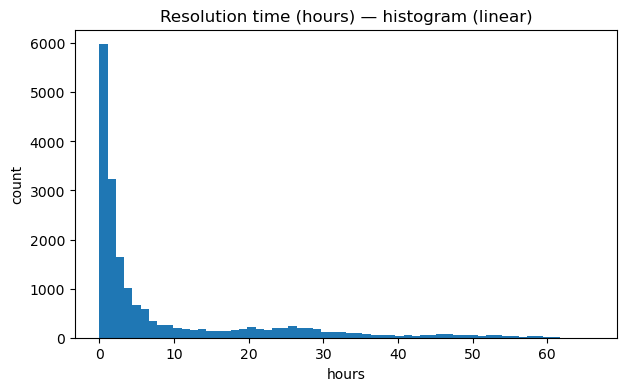

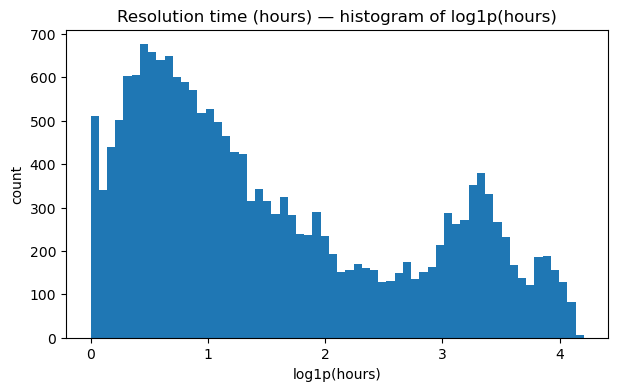

count    18894.000000
mean         8.827548
std         12.997412
min          0.000000
50%          2.318889
75%         11.172986
90%         28.556333
95%         38.251319
99%         54.333253
max         66.066389
Name: resolution_hours, dtype: float64

In [23]:
x = dur_closed.copy()

plt.figure(figsize=(7,4))
plt.hist(x.clip(lower=0), bins=60)
plt.title("Resolution time (hours) — histogram (linear)")
plt.xlabel("hours")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(np.log1p(x.clip(lower=0)), bins=60)
plt.title("Resolution time (hours) — histogram of log1p(hours)")
plt.xlabel("log1p(hours)")
plt.ylabel("count")
plt.show()

# Pandas built in method for statistical summaries of a series or DataFrame
# Also include specific quantities listed
x.describe(percentiles=[0.5,0.75,0.9,0.95,0.99])


## A.5 Central Tendency (Mean vs Median vs Trimmed Mean)

The mean answers "What's the average", but it is pulled by extreme values.  

A good EDA habit:
* report both **mean** and **median**
* add a **trimmed mean** (drop top/bottom p%) to estimate typical under contamination

In [11]:
def trimmed_mean(x: pd.Series, trim: float = 0.05) -> float:
    x2 = x.dropna().sort_values()
    n = len(x2)
    k = int(n * trim)
    if n- 2*k <= 0:
        return float(x2.mean())
    return float(x2.iloc[k:n-k].mean())

x = dur_closed.copy()
x = x[x >= 0]

summary_center = pd.DataFrame({
    "metric": ["mean", "median", "trimmed_mean_5pct"],
    "value_hours": [float(x.mean()), float(x.median()), trimmed_mean(x, 0.05)]
})
summary_center

,metric,value_hours
0,mean,8.827548
1,median,2.318889
2,trimmed_mean_5pct,7.113586


### Visual: Mean and Median Markers  

Plot a histogram and mark the mean and median with vertical lines

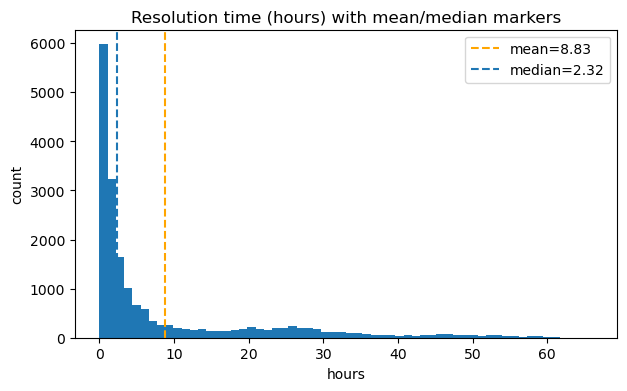

In [12]:
plt.figure(figsize=(7,4))
plt.hist(x, bins=60)
plt.axvline(x.mean(), linestyle="--", c="orange", label=f"mean={x.mean():.2f}")
plt.axvline(x.median(), linestyle="--", label=f"median={x.median():.2f}")
plt.title("Resolution time (hours) with mean/median markers")
plt.xlabel("hours")
plt.ylabel("count")
plt.legend()
plt.show()

## A.6 Spread and Variability

Useful spread summaries for skewed distributions:  
* **std dev** - sensitive to tails
* **IQR** - robust
* **Quantiles** - p50/p90/p95/p99, often matter more than the mean


In [13]:
def iqr(x: pd.Series) -> float:
    return float(x.quantile(0.75) - x.quantile(0.25))

spread = {
    "std_hours": float(x.std(ddof=1)),
    "iqr_hours": iqr(x),
    "p50_hours": float(x.quantile(0.50)),
    "p90_hours": float(x.quantile(0.90)),
    "p95_hours": float(x.quantile(0.95)),
    "p99_hours": float(x.quantile(0.99)),
    "max_hours": float(x.max()),
}

pd.DataFrame([spread]).T.rename(columns={0:"value"})

,value
std_hours,12.997412
iqr_hours,10.344653
p50_hours,2.318889
p90_hours,28.556333
p95_hours,38.251319
p99_hours,54.333253
max_hours,66.066389


### Visual: Boxplot (Tail sensitivity)  

Boxplots show median + IQR and make outliers explicit

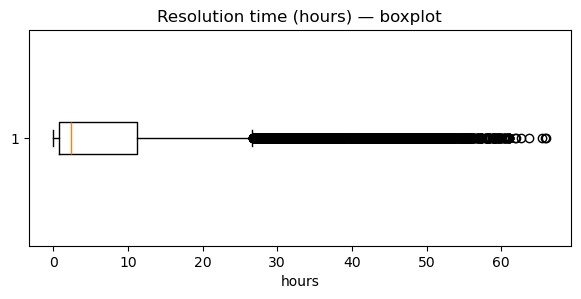

Tip: if the tail dominates, consider plotting on a log scale or trimming for visualization only.


In [14]:
plt.figure(figsize=(7,2.8))
plt.boxplot(x, vert=False, showfliers=True)
plt.title("Resolution time (hours) — boxplot")
plt.xlabel("hours")
plt.show()

print("Tip: if the tail dominates, consider plotting on a log scale or trimming for visualization only.")

## A.7 Robust Statistics (MAD + winsorization)

Robust statistics are dosigned to fail gracefully when the data is contaminated by:
* logging errors
* rare but real events
* unit glitches
* extreme long-tail cases

We will compute
* MAD - median absolute deviation
* Winsorized version of the data (clip to percentiles) and compare how summaries change

In [15]:
def mad(x: pd.Series) -> float:
    x2 = x.dropna()
    med = x2.median()
    return float((x2 - med).abs().median())

def winsorize(x: pd.Series, lower_q=0.01, upper_q=0.99) -> pd.Series:
    lo = x.quantile(lower_q)
    hi = x.quantile(upper_q)
    return x.clip(lower=float(lo), upper=float(hi))

x_w = winsorize(x, 0.05, 0.95)

robust_summary = pd.DataFrame({
    "stat": ["mean", "median", "std", "IQR", "MAD", "p95", "p99", "max"],
    "raw_hours": [
        float(x.mean()),
        float(x.median()),
        float(x.std(ddof=1)),
        iqr(x),
        mad(x),
        float(x.quantile(0.95)),
        float(x.quantile(0.99)),
        float(x.max()),
    ],
    "winsor_hours": [
        float(x_w.mean()),
        float(x_w.median()),
        float(x_w.std(ddof=1)),
        iqr(x_w),
        mad(x_w),
        float(x_w.quantile(0.95)),
        float(x_w.quantile(0.99)),
        float(x_w.max()),
    ],
})
robust_summary


,stat,raw_hours,winsor_hours
0,mean,8.827548,8.322420
1,median,2.318889,2.318889
2,std,12.997412,11.469387
3,IQR,10.344653,10.344653
4,MAD,1.919861,1.919861
5,p95,38.251319,38.251003
6,p99,54.333253,38.251319
7,max,66.066389,38.251319


### Visual: Raw vs Winsorized - for interpretation  

Winsorization is **not** "cleaning away the truth", it is a way to ask:  

What do the summaries look like if we limit extreme influence?


We will compare histograms

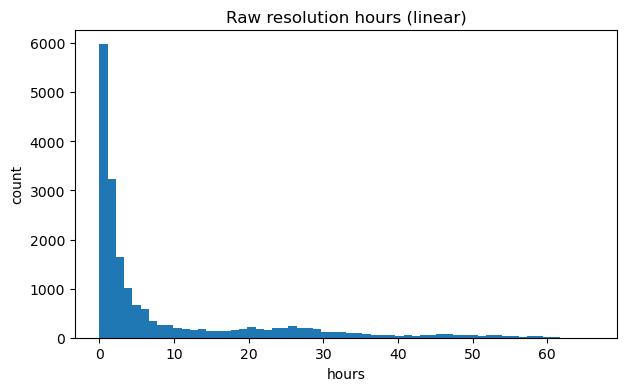

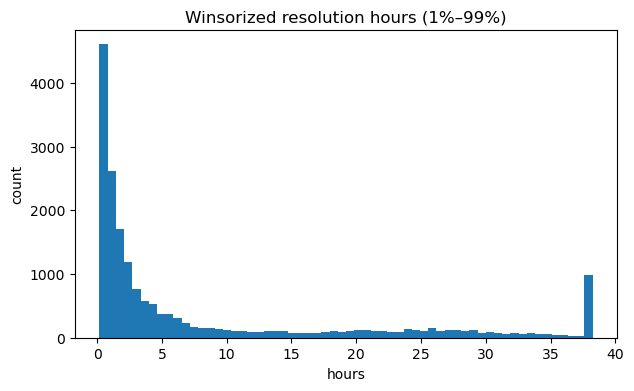

In [16]:
plt.figure(figsize=(7,4))
plt.hist(x, bins=60)
plt.title("Raw resolution hours (linear)")
plt.xlabel("hours")
plt.ylabel("count")
plt.show()

plt.figure(figsize=(7,4))
plt.hist(x_w, bins=60)
plt.title("Winsorized resolution hours (1%–99%)")
plt.xlabel("hours")
plt.ylabel("count")
plt.show()

## A.8 Group Summaries (Agency-level typical vs tail)

Descriptive statistics get much more useful when you compare groups. We will compute, for the most common agencies:
* count
* mean
* median
* p90/ p95

Then we will visualize the distributions for the top few agencies.

In [17]:
if "agency" not in df3.columns:
    raise ValueError("No 'agency' column found in the feature table")

tmp = df3.loc[mask].copy()
tmp["resolution_hours"] = dur_closed.values

# Keep plausible non-negative durations for summaries
tmp = tmp.loc[tmp["resolution_hours"].notna() & (tmp["resolution_hours"] >= 0)].copy()

top_agencies = tmp["agency"].astype("string").value_counts().head(8).index.tolist()

def q(x, p):
    return float(x.quantile(p))

group_stats = (
    tmp.loc[tmp["agency"].isin(top_agencies)]
       .groupby("agency")["resolution_hours"]
       .agg(
           n="count",
           mean="mean",
           median="median",
           p90=lambda s: q(s, 0.90),
           p95=lambda s: q(s, 0.95),
       )
       .sort_values("n", ascending=False)
)

group_stats

,n,mean,median,p90,p95
agency,,,,,
NYPD,11440,2.065904,1.278056,4.785667,6.402319
HPD,4458,23.999943,23.354861,46.873194,52.485792
DSNY,794,18.759539,20.099722,33.866306,46.265167
DOT,755,8.385227,2.448611,22.958833,29.547472
DEP,711,6.089803,1.033333,21.366667,28.458333
DHS,227,18.050852,12.941389,45.522667,49.234139
DOB,147,9.495754,8.230000,29.426111,34.048278
DOHMH,125,13.816304,14.663611,24.342278,24.479667


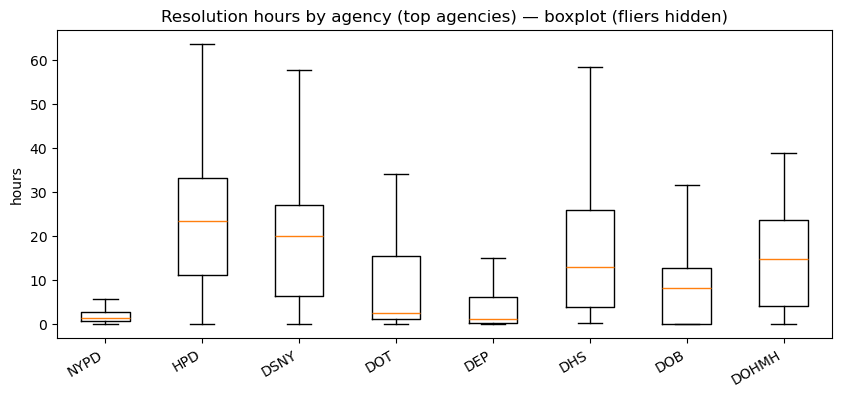

Note: fliers hidden here to keep the plot readable. Tail risk still exists—use quantiles to quantify it.


In [20]:
# Boxplot by agency (top agencies only)
data = [tmp.loc[tmp["agency"] == a, "resolution_hours"] for a in top_agencies]

plt.figure(figsize=(10,4))
plt.boxplot(data, tick_labels=[str(a) for a in top_agencies], showfliers=False)
plt.title("Resolution hours by agency (top agencies) — boxplot (fliers hidden)")
plt.ylabel("hours")
plt.xticks(rotation=30, ha="right")
plt.show()

print("Note: fliers hidden here to keep the plot readable. Tail risk still exists—use quantiles to quantify it.")

## A.9 Deliverable: a short narrative

Write 5–8 bullet points that answer:

1) **What is “typical” resolution time overall? (median + context)**  
    The resolution time comes from the median of the `resolution_hours` field. From A.4, we can see that when running .describe, the median (p50) is **2.318889**
    
2) **How variable is it? (IQR and p90/p95)**  
    *How much do the resolution times differ from each other*. This is asking about the spread or dispersion of the data.  
    IQR = 0.75 - 0.25 (The range that contains the middle 50% of the data.  
    From A.4, we can see the IQR = 10.34 hours, p90 = 28.56, p95 = 38.25
    
3) **How heavy is the tail? (p99 vs median, max)**  
    How extreme are the worst-case resolution times compared to typical?  
    From A.4, we can see that p99 = 54.33, median = 2.32, max = 66.07
    
4) **Which agencies look different, and how? (median vs p95)**
    median resolution time -> typical case
    p95 -> bad, but not extreme, case
    From A.8, we can see that NYPD is the fastest and HPD is the slowest.

5) **What would you investigate next? (data issues vs real effects)**
    We need to determine if there are issues that are caused by bad data vs real issues    

Use numbers. Be explicit about what could be misleading.

### Optional: quick “sanity checks” you should always run

Even in an EDA notebook, act like an engineer:
- Are there negative durations?  
- Are there impossible timestamps?  
- Do missing values cluster by agency/category?  
- Are there sudden shifts by day?

You’ll formalize these as validation checks again in later modules — but build the habit now.

# Module 3.B - Visualization as Thinking (NYC311)

This notebook continues with the NYC311 feature table built in Module 2.  

**Goal:** use a small set of high-leverage plots to build a correct mental model of the data:  
* what's common vs rare
* what's variable vs stable
* what differs by group (agency, complaint type, borough)
* what changes over time (drift, seasonality, pipeline issues)

You will focus on interpretation and next questions, not "pretty charts"

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 140)
pd.set_option("display.width", 160)

## 3B.1 Load NYC 311 Normalized Table (from 3.A)

If the normalized file does not exist yet, this notebook will:  
1. Fall back to Module 2 artifacts
2. Rebuild the normalized table once
3. Cache it for future notebooks.

In [3]:
# Prefer the normalized cache written by Module 3.A (faster, consistent columns)
M3_DATA_DIR = Path("work/m3/data")
NORM_PATH = M3_DATA_DIR / "nyc311_features_norm.parquet"

# Fall back to Module 2 artifacts if the cache does not exist
WORK_DIR = Path("work")
MODULE2_DIR = WORK_DIR / "m2"
DATA_DIR = MODULE2_DIR / "data"

RAW_DIR = DATA_DIR / "raw"
WH_DIR = DATA_DIR / "warehouse"

CSV_PATH = RAW_DIR / "nyc311_last14d.csv"
FEATURES_PATH = WH_DIR / "nyc311_requests_features.parquet"
PART_DIR = WH_DIR / "partitions"

print("Normalized cache:", NORM_PATH, "| exists?", NORM_PATH.exists())
print("Features:", FEATURES_PATH, "| exists?", FEATURES_PATH.exists())
print("Partitions:", PART_DIR, "| exists?", PART_DIR.exists())

Normalized cache: work/m3/data/nyc311_features_norm.parquet | exists? True
Features: work/m2/data/warehouse/nyc311_requests_features.parquet | exists? True
Partitions: work/m2/data/warehouse/partitions | exists? True


In [4]:
def load_or_build_normalized() -> pd.DataFrame:
    
    # 1 - Preferred: normalized chache from 3.A
    if NORM_PATH.exists():
        df = pd.read_parquet(NORM_PATH)
        df["_source"] = "3.A_normalized_cache"
        return df

    # 2 - Else: load raw features (2.C) or curated partitions (2.D)
    def load_features_raw() -> pd.DataFrame:
        if FEATURES_PATH.exists():
            d = pd.read_parquet(FEATURES_PATH)
            d["_source"] = "2.C_features_parquet"
            return d

        if PART_DIR.exists():
            parts = sorted(PART_DIR.glob("created_day=*/requests.parquet"))
            if not parts:
                raise FileNotFoundError("No partitions found in warehouse/partitions/")
            d = pd.concat([pd.read_parquet(p) for p in parts], ignore_index=True)
            d["_source"] = "2.D_partitioned_curated"
            return d

        raise FileNotFoundError(
            "No features parquet and no partitions found. Run Module 2.C or 2.D first."
        )

    df_raw = load_features_raw()

    # 3 - Normalize (same idea as 3.A)
    df2 = df_raw.copy()

    if "created_date" in df2.columns and not np.issubdtype(df2["created_date"].dtype, np.datetime64):
        df2["created_date"] = pd.to_datetime(df2["created_date"], errors="coerce")
    if "closed_date" in df2.columns and not np.issubdtype(df2["closed_date"].dtype, np.datetime64):
        df2["closed_date"] = pd.to_datetime(df2["closed_date"], errors="coerce")

    if "created_day" in df2.columns:
        if df2["created_day"].dtype == "object":
            df2["created_day"] = pd.to_datetime(df2["created_day"], errors="coerce").dt.date
    else:
        if "created_date" in df2.columns:
            df2["created_day"] = df2["created_date"].dt.date

    if "status" in df2.columns:
        df2["status"] = df2["status"].astype("string").str.strip().str.title()

    if "is_closed" not in df2.columns and "status" in df2.columns:
        df2["is_closed"] = (df2["status"] == "Closed").astype(int)

    if "resolution_hours" in df2.columns:
        df2["resolution_hours"] = pd.to_numeric(df2["resolution_hours"], errors="coerce")
    else:
        if "created_date" in df2.columns and "closed_date" in df2.columns:
            df2["resolution_hours"] = (df2["closed_date"] - df2["created_date"]).dt.total_seconds() / 3600
        else:
            raise ValueError("No resolution_hours and not enough columns to compute it.")

    if "created_date" in df2.columns:
        df2["created_hour"] = df2["created_date"].dt.hour
        df2["created_dow"] = df2["created_date"].dt.dayofweek

    # Write cache for future notebooks
    M3_DATA_DIR.mkdir(parents=True, exist_ok=True)
    df2.to_parquet(NORM_PATH, index=False)

    df2["_source"] = df_raw["_source"].iloc[0] + " -> normalized_and_cached"
    return df2

df2 = load_or_build_normalized()
print("Loaded:", df2["_source"].iloc[0])
print("Shape:", df2.shape)
df2.head(5)

Loaded: 3.A_normalized_cache
Shape: (50000, 25)


,unique_key,created_date,created_day,created_hour,dayofweek,is_weekend,agency,borough_norm,complaint_topk,zip_missing,kw_noise,kw_rodent,kw_water,street_number,n_requests,closed_rate,median_resolution_hours,agency_n_requests,agency_closed_rate,agency_median_resolution,status,is_closed,resolution_hours,_source,created_dow
0,67720523,2026-01-30 01:51:21,2026-01-30,1,4,0,NYPD,<NA>,other,1,1,0,0,<NA>,280,0.435714,0.480972,11651,0.981890,1.277778,Unspecified,0,NaN,3.A_normalized_cache,4
1,67746090,2026-01-30 01:51:04,2026-01-30,1,4,0,DOE,BROOKLYN,other,0,0,0,0,911,280,0.435714,0.480972,144,0.520833,7.605000,In Progress,0,NaN,3.A_normalized_cache,4
2,67758820,2026-01-30 01:50:53,2026-01-30,1,4,0,NYPD,MANHATTAN,noise - residential,0,1,0,0,936,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,3.A_normalized_cache,4
3,67707975,2026-01-30 01:50:52,2026-01-30,1,4,0,NYPD,STATEN ISLAND,noise - residential,0,1,0,0,190,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,3.A_normalized_cache,4
4,67771794,2026-01-30 01:50:32,2026-01-30,1,4,0,TLC,QUEENS,other,0,0,0,0,<NA>,280,0.435714,0.480972,246,0.117886,16.582778,In Progress,0,NaN,3.A_normalized_cache,4


## 3B.2 Inspect Key Columns

Ensure key columns are present in our loaded normalized dataset.

In [6]:
print("Source:", df2["_source"].iloc[0] if "_souce" in df2.columns else "unknown")
print("Shape:", df2.shape)

print("Key columns present:")
for c in [
    "unique_key", "created_date", "created_day",
    "agency", "complaint_type", "borough",
    "status", "is_closed", 
    "resolution_hours","created_hour","created_dow"
]:
    if c in df2.columns:
        print(" Yes - ", c)

df2.head(3)

Source: unknown
Shape: (50000, 25)
Key columns present:
 Yes -  unique_key
 Yes -  created_date
 Yes -  created_day
 Yes -  agency
 Yes -  status
 Yes -  is_closed
 Yes -  resolution_hours
 Yes -  created_hour
 Yes -  created_dow


,unique_key,created_date,created_day,created_hour,dayofweek,is_weekend,agency,borough_norm,complaint_topk,zip_missing,kw_noise,kw_rodent,kw_water,street_number,n_requests,closed_rate,median_resolution_hours,agency_n_requests,agency_closed_rate,agency_median_resolution,status,is_closed,resolution_hours,_source,created_dow
0,67720523,2026-01-30 01:51:21,2026-01-30,1,4,0,NYPD,<NA>,other,1,1,0,0,<NA>,280,0.435714,0.480972,11651,0.981890,1.277778,Unspecified,0,NaN,3.A_normalized_cache,4
1,67746090,2026-01-30 01:51:04,2026-01-30,1,4,0,DOE,BROOKLYN,other,0,0,0,0,911,280,0.435714,0.480972,144,0.520833,7.605000,In Progress,0,NaN,3.A_normalized_cache,4
2,67758820,2026-01-30 01:50:53,2026-01-30,1,4,0,NYPD,MANHATTAN,noise - residential,0,1,0,0,936,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,3.A_normalized_cache,4


## 3B.3 Build the Main Analysis Series: Closed, Non-negative Resolution Times

We will analyze resolution time primarily on **closed** requests with **non-negative** durations. We keep extreme values (tail risk) but will use log views for interprebility

In [7]:
is_closed = df2["is_closed"] == 1 if "is_closed" in df2.columns else pd.Series([True]*len(df2))
dur = pd.to_numeric(df2["resolution_hours"], errors="coerce")

mask = is_closed & dur.notna() & (dur >= 0)
x = dur.loc[mask].copy()

print("Closed + non-negative duration rows:", len(x), "out of", len(df2))
print("Min hours:", float(x.min()), "Max hours:", float(x.max()))
x.describe(percentiles=[0.5, 0.9, 0.95, 0.99])

Closed + non-negative duration rows: 18894 out of 50000
Min hours: 0.0 Max hours: 66.0663888888889


count    18894.000000
mean         8.827548
std         12.997412
min          0.000000
50%          2.318889
90%         28.556333
95%         38.251319
99%         54.333253
max         66.066389
Name: resolution_hours, dtype: float64

## 3B.4 Relationships - not just correlation

For NYC 311, many useful predictors are categorical. But you can still explore relationships using:  
* derived time features (`created_hour`, `created_dow`)
* simple engineered features (e.g., text length)
* aggregated views (daily volume vs median resolution)

We will do three relationship-style plots:  
1. **Hour of day vs resolution** - hexbin
2. **Day of week vs resolution** - boxplot + quantiles
3. **Daily volume vs daily median resolution** - scatter

In [11]:
tmp = df2.loc[mask].copy()
tmp["resolution_hours"] = x.values

# Keep only rows with time features when available
time_cols = [c for c in ["created_hour", "created_dow"] if c in tmp.columns]
if time_cols:
    tmp = tmp.dropna(subset=time_cols)

print("Rows for relationship plots", len(tmp))
tmp[["resolution_hours"] + time_cols].head()


Rows for relationship plots 18894


,resolution_hours,created_hour,created_dow
41,0.373056,1,4
43,0.181667,1,4
45,0.353056,1,4
49,0.300278,1,4
51,0.095000,1,4


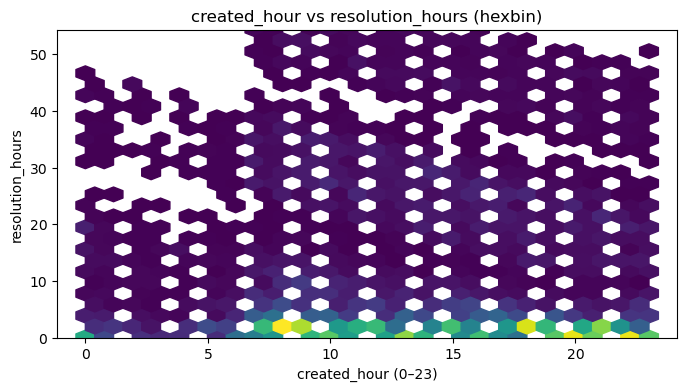

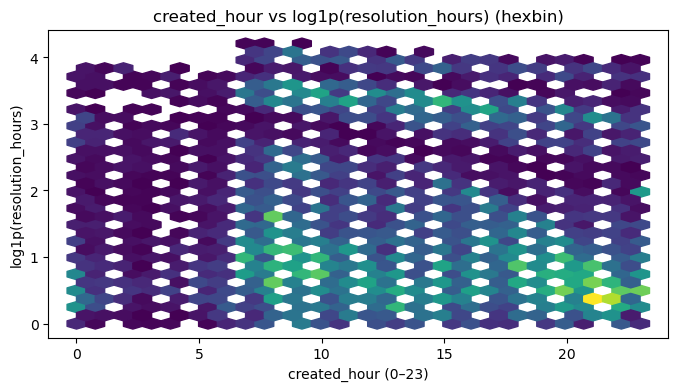

In [12]:
# 1 - Hour of day vs resolution (hexbin handles overlap)
if "created_hour" in tmp.columns:
    y99 = float(np.quantile(tmp["resolution_hours"], 0.99))

    plt.figure(figsize=(8,4))
    plt.hexbin(tmp["created_hour"], tmp["resolution_hours"], gridsize=30, mincnt=1)
    plt.title("created_hour vs resolution_hours (hexbin)")
    plt.xlabel("created_hour (0–23)")
    plt.ylabel("resolution_hours")
    plt.ylim(0, y99)  # trim view for readability (tail still exists)
    plt.show()

    plt.figure(figsize=(8,4))
    plt.hexbin(tmp["created_hour"], np.log1p(tmp["resolution_hours"]), gridsize=30, mincnt=1)
    plt.title("created_hour vs log1p(resolution_hours) (hexbin)")
    plt.xlabel("created_hour (0–23)")
    plt.ylabel("log1p(resolution_hours)")
    plt.show()
else:
    print("No created_hour column available — skip this relationship plot.")

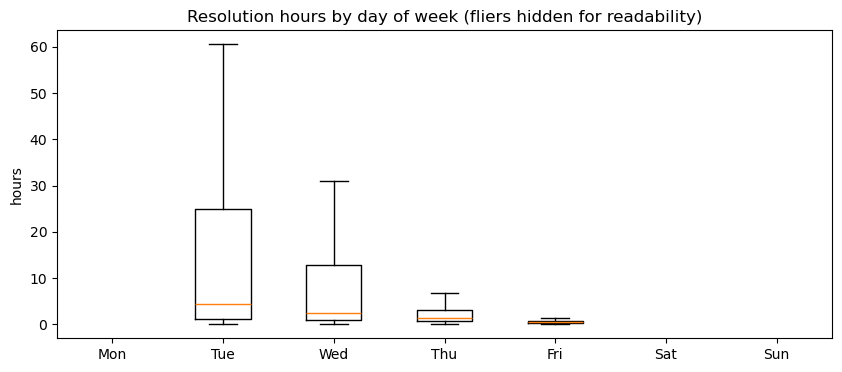

In [14]:
# 2 - Day of week vs resolution (boxplot)

if "created_dow" in tmp.columns:
    labels = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    data = [tmp.loc[tmp["created_dow"] == i, "resolution_hours"] for i in range(7)]

    plt.figure(figsize=(10,4))
    plt.boxplot(data, tick_labels=labels, showfliers=False)
    plt.title("Resolution hours by day of week (fliers hidden for readability)")
    plt.ylabel("hours")
    plt.show()

    q = tmp.groupby("created_dow")["resolution_hours"].quantile([0.5, 0.9, 0.95]).unstack()
    q.index = [labels[i] for i in q.index]
    q.rename(columns={0.5:"p50", 0.9:"p90", 0.95:"p95"})
else:
    print("No created_dow column available — skip this relationship plot.")

In [16]:
# 3 - Daily volume vs daily median resolution
if "created_day" not in tmp.columns:
    raise ValueError("created_day missing; needed for daily aggregation.")

daily = (
    tmp.groupby("created_day")
       .agg(
           n=("resolution_hours", "size"),
           median=("resolution_hours", "median"),
           p95=("resolution_hours", lambda s: float(s.quantile(0.95))),
       )
       .reset_index()
)

daily.head()

,created_day,n,median,p95
0,2026-01-27,7109,4.429444,50.172167
1,2026-01-28,6817,2.536667,30.207444
2,2026-01-29,4846,1.410694,9.846597
3,2026-01-30,122,0.480972,1.274111


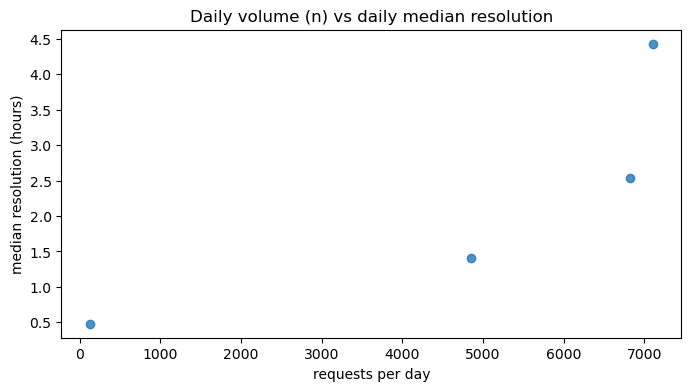

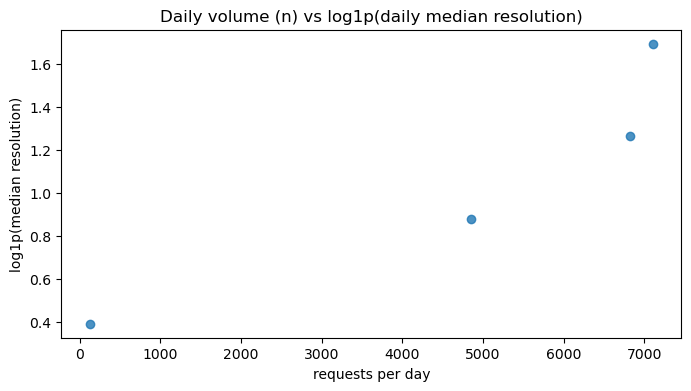

Correlation (n vs median): 0.8408819964031107


In [17]:
plt.figure(figsize=(8,4))
plt.scatter(daily["n"], daily["median"], alpha=0.8)
plt.title("Daily volume (n) vs daily median resolution")
plt.xlabel("requests per day")
plt.ylabel("median resolution (hours)")
plt.show()

plt.figure(figsize=(8,4))
plt.scatter(daily["n"], np.log1p(daily["median"]), alpha=0.8)
plt.title("Daily volume (n) vs log1p(daily median resolution)")
plt.xlabel("requests per day")
plt.ylabel("log1p(median resolution)")
plt.show()

print("Correlation (n vs median):", float(np.corrcoef(daily["n"], daily["median"])[0,1]))

## 3B.5 Group Comparisons (Agency, Complaint Type, Borough)

Group comparisons are where EDA becomes actionable.  

We will compute for top groups:
* count
* median
* p90/p95/p99

Then we will plot boxplots (fliers hidden) for readability

In [20]:
def top_groups(series: pd.Series, k: int = 8):
    return series.astype("string").value_counts().head(k).index.tolist()

def boxplot_topk(df: pd.DataFrame, col: str, k: int = 8):
    top = top_groups(df[col], k)
    data = [df.loc[df[col].astype("string") == g, "resolution_hours"] for g in top]

    plt.figure(figsize=(12,4))
    plt.boxplot(data, tick_labels=[str(g) for g in top], showfliers=False)
    plt.title(f"Resolution hours by {col} (top {k}; fliers hidden)")
    plt.ylabel("hours")
    plt.xticks(rotation=30, ha="right")
    plt.show()

    qtab = (
        df.loc[df[col].astype("string").isin(top)]
          .groupby(col)["resolution_hours"]
          .quantile([0.5, 0.9, 0.95, 0.99])
          .unstack()
          .rename(columns={0.5:"p50", 0.9:"p90", 0.95:"p95", 0.99:"p99"})
          .sort_values("p50", ascending=False)
    )
    return qtab

group_cols = [c for c in ["agency", "complaint_topk", "borough_norm"] if c in tmp.columns]
group_cols

['agency', 'complaint_topk', 'borough_norm']


=== agency ===


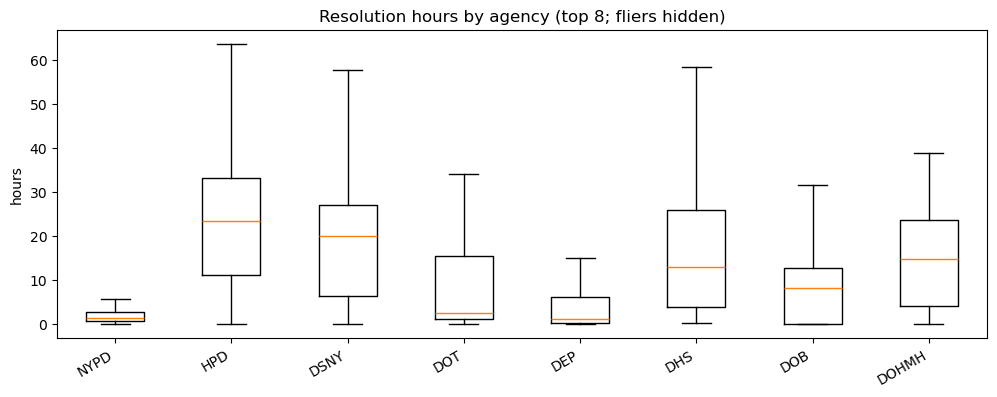

,p50,p90,p95,p99
agency,,,,
HPD,23.354861,46.873194,52.485792,59.008550
DSNY,20.099722,33.866306,46.265167,57.975308
DOHMH,14.663611,24.342278,24.479667,37.269511
DHS,12.941389,45.522667,49.234139,63.881500
DOB,8.230000,29.426111,34.048278,37.081400
DOT,2.448611,22.958833,29.547472,48.556106
NYPD,1.278056,4.785667,6.402319,12.438022
DEP,1.033333,21.366667,28.458333,46.200000



=== complaint_topk ===


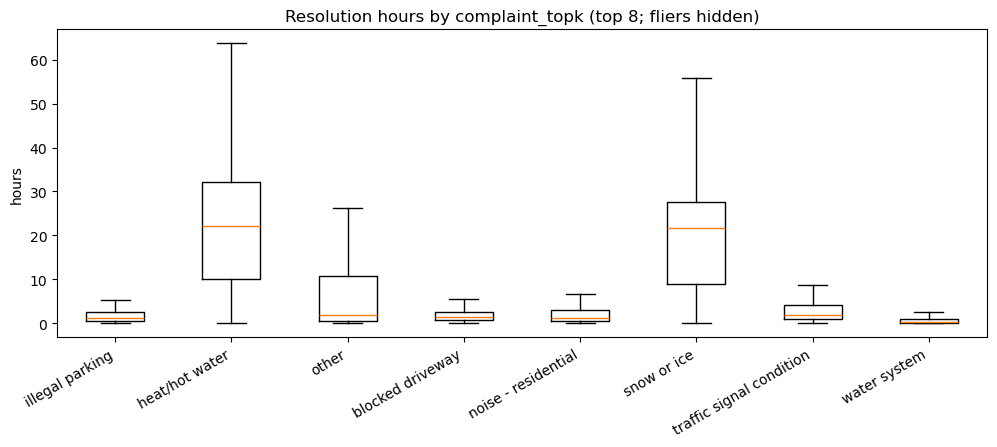

,p50,p90,p95,p99
complaint_topk,,,,
heat/hot water,22.087917,45.873417,50.924611,58.213108
snow or ice,21.778333,33.668333,46.536500,58.225383
traffic signal condition,1.991667,16.545000,23.236667,42.024000
other,1.889722,23.800861,29.224014,49.445303
blocked driveway,1.438611,4.671528,6.591875,13.005497
noise - residential,1.302083,5.653889,6.581333,12.800778
illegal parking,1.256667,4.598889,6.288611,12.437778
water system,0.233333,5.690000,15.490000,39.082667



=== borough_norm ===


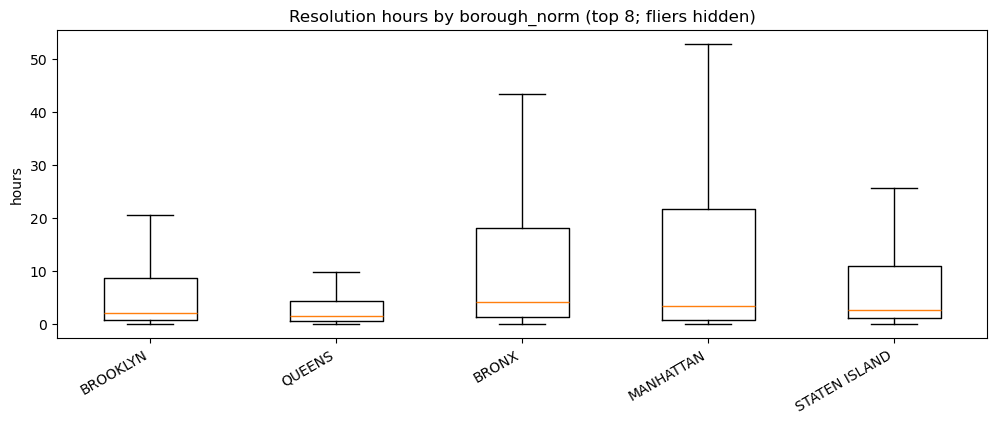

,p50,p90,p95,p99
borough_norm,,,,
BRONX,4.109861,33.580556,44.834097,54.840944
MANHATTAN,3.446389,34.813944,45.679472,54.918061
STATEN ISLAND,2.707083,29.526333,43.941764,57.731478
BROOKLYN,2.054167,26.319167,34.047639,52.719639
QUEENS,1.541944,20.184944,28.853278,48.394400


In [21]:
for c in group_cols:
    print("\n===", c, "===")
    qtab = boxplot_topk(tmp, c, 8)
    display(qtab)

## 3B.6 Time Behavior (Drift, Spikes, Process Changes)

We will plot daily:
* request volume
* median resolution
* p95 resolution

A single weird day can be:
* a real operational event
* a data pipeline / logging issue
* missing data (partial ingest)

Treat anomalies as a promt to investigate

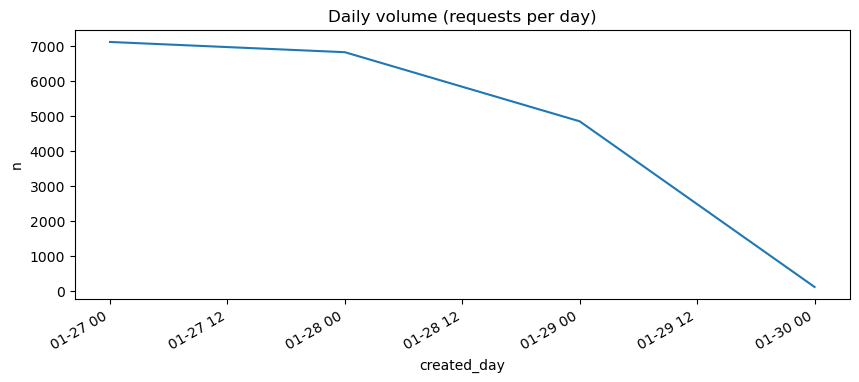

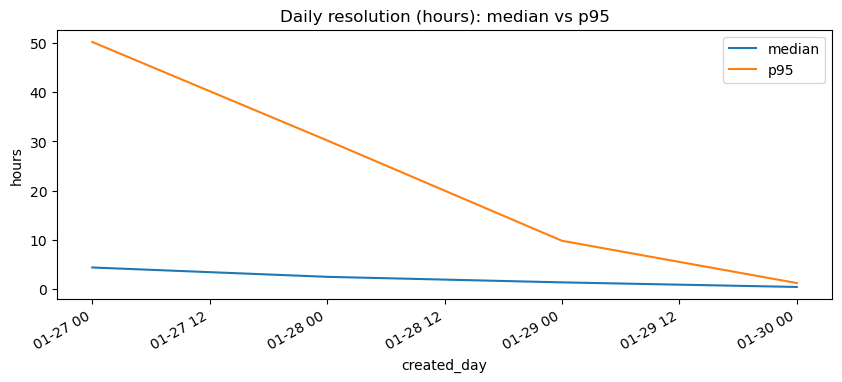

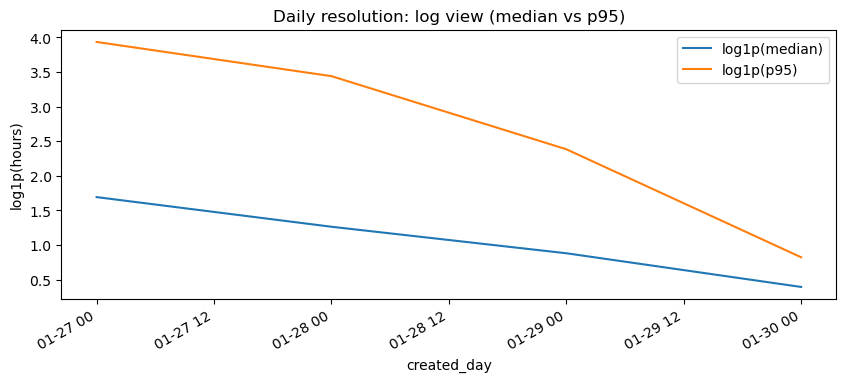

,created_day,n,median,p95
0,2026-01-27,7109,4.429444,50.172167
1,2026-01-28,6817,2.536667,30.207444
2,2026-01-29,4846,1.410694,9.846597
3,2026-01-30,122,0.480972,1.274111


In [22]:
daily_sorted = daily.sort_values("created_day").copy()

plt.figure(figsize=(10,3.5))
plt.plot(daily_sorted["created_day"], daily_sorted["n"])
plt.title("Daily volume (requests per day)")
plt.xlabel("created_day")
plt.ylabel("n")
plt.xticks(rotation=30, ha="right")
plt.show()

plt.figure(figsize=(10,3.5))
plt.plot(daily_sorted["created_day"], daily_sorted["median"], label="median")
plt.plot(daily_sorted["created_day"], daily_sorted["p95"], label="p95")
plt.title("Daily resolution (hours): median vs p95")
plt.xlabel("created_day")
plt.ylabel("hours")
plt.xticks(rotation=30, ha="right")
plt.legend()
plt.show()

plt.figure(figsize=(10,3.5))
plt.plot(daily_sorted["created_day"], np.log1p(daily_sorted["median"]), label="log1p(median)")
plt.plot(daily_sorted["created_day"], np.log1p(daily_sorted["p95"]), label="log1p(p95)")
plt.title("Daily resolution: log view (median vs p95)")
plt.xlabel("created_day")
plt.ylabel("log1p(hours)")
plt.xticks(rotation=30, ha="right")
plt.legend()
plt.show()

daily_sorted.tail(10)

# 3B.7 EDA Narrative

Write bullets that answer:

1. **What does the distribution of resolution time look like?**
    Most requests are resolved quickly (2.3 hours), but there are a small number of long cases that increase the mean. 

2. **Which plot changed your mind the most, and why?**
    The histogram of log1p (resolution hours) helped show a more accurate representation of the resolution time

3. **What differs by group (agency/complaint type/borough)?**
    Resolution times differ substantially depending on the group

4. **What changes over time? Mention a specific day if something stands out.**
    As volume drops, median resolution time decreases sharply

5. **What is your next investigation?**
    Investigate the anomalies (Jan 30)

# Module 3.C Correlation vs Causation (NYC 311)

This module practices casual hygiene on the NYC 311 dataset:  

* **Correlation scan:** treat correlations as *hypotheses*, not truths
* **Spurious Check:** re-run the scan in different time windows (stability)
* **Confounding Check:** stratify by likely confounders (agency, complaint type)
* **Time-order/leakage check:** ensure "predictors" are available at creation time

**Deliverable:** a short memo:
* 3 correlations
* 1 confounder
* 1 next-step test each

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 160)
pd.set_option("display.width", 160)


## 3C.1 Load NYC 311 Normalized Table

Load the normalized cache written by Module 3.A (faster, consistent columns)

In [3]:
# Prefer the normalized cache written by Module 3.A (faster, consistent columns)
M3_DATA_DIR = Path("work/m3/data") 
NORM_PATH = M3_DATA_DIR / "nyc311_features_norm.parquet"

print("Normalized cache:", NORM_PATH, "| exists?", NORM_PATH.exists())

Normalized cache: work/m3/data/nyc311_features_norm.parquet | exists? True


In [4]:
def load_normalized() -> pd.DataFrame:
    # 1) Preferred: normalized cache from 3.A
    if NORM_PATH.exists():
        df = pd.read_parquet(NORM_PATH)
        df["_source"] = "3.A_normalized_cache"
        return df

    raise FileNotFoundError(
        "No normalized table found. Run Module 3.A first."
    )
    
df = load_normalized()
print("Loaded:", df["_source"].iloc[0] if "_source" in df.columns else "unknown")
print("Shape:", df.shape)
df.head(5)

Loaded: 3.A_normalized_cache
Shape: (50000, 25)


,unique_key,created_date,created_day,created_hour,dayofweek,is_weekend,agency,borough_norm,complaint_topk,zip_missing,kw_noise,kw_rodent,kw_water,street_number,n_requests,closed_rate,median_resolution_hours,agency_n_requests,agency_closed_rate,agency_median_resolution,status,is_closed,resolution_hours,_source,created_dow
0,67720523,2026-01-30 01:51:21,2026-01-30,1,4,0,NYPD,<NA>,other,1,1,0,0,<NA>,280,0.435714,0.480972,11651,0.981890,1.277778,Unspecified,0,NaN,3.A_normalized_cache,4
1,67746090,2026-01-30 01:51:04,2026-01-30,1,4,0,DOE,BROOKLYN,other,0,0,0,0,911,280,0.435714,0.480972,144,0.520833,7.605000,In Progress,0,NaN,3.A_normalized_cache,4
2,67758820,2026-01-30 01:50:53,2026-01-30,1,4,0,NYPD,MANHATTAN,noise - residential,0,1,0,0,936,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,3.A_normalized_cache,4
3,67707975,2026-01-30 01:50:52,2026-01-30,1,4,0,NYPD,STATEN ISLAND,noise - residential,0,1,0,0,190,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,3.A_normalized_cache,4
4,67771794,2026-01-30 01:50:32,2026-01-30,1,4,0,TLC,QUEENS,other,0,0,0,0,<NA>,280,0.435714,0.480972,246,0.117886,16.582778,In Progress,0,NaN,3.A_normalized_cache,4


## 3C.2 Choose the Outcome (and a Clean Analysis Slice)

Typically use:
* Outcome - `resolution hours`
* Analysis slice - closed cases with non-negative resolution time
* Optional "slow" flag - whether a case is slower than a high quantile

In [5]:
df2 = df.copy()

# Basic slice: closed cases and plausible non-negative resolution
if "is_closed" in df2.columns:
    is_closed = df2["is_closed"] == 1
elif "status" in df2.columns:
    is_closed = df2["status"].isin(["CLOSED", "RESOLVED"])
else:
    is_closed = pd.Series([True] * len(df2))

y = df2["resolution_hours"].copy() if "resolution_hours" in df2.columns else pd.Series([np.nan] * len(df2))

mask = is_closed & y.notna() & np.isfinite(y) & (y >= 0)
dfc = df2.loc[mask].copy()
y = dfc["resolution_hours"].astype(float)

print("Rows (raw):", len(df2))
print("Rows (analysis slice):", len(dfc))
print("Outcome summary (resolution_hours):")
print(y.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))


Rows (raw): 50000
Rows (analysis slice): 18894
Outcome summary (resolution_hours):
count    18894.000000
mean         8.827548
std         12.997412
min          0.000000
50%          2.318889
90%         28.556333
95%         38.251319
99%         54.333253
max         66.066389
Name: resolution_hours, dtype: float64


In [6]:
# Optional: define a "slow" binary outcome as above p95 within the slice
p95 = float(y.quantile(0.95))
dfc["is_slow_p95"] = (dfc["resolution_hours"] >= p95).astype(int)
print("p95 threshold:", p95)
print("Slow rate:", float(dfc["is_slow_p95"].mean()))


p95 threshold: 38.25131944444444
Slow rate: 0.05001587805652588


### Look at the outcome distribution  

Before correlating anything with the outcome, look at its shape. NYC 311 resolution time is typically heavy-tailes. Heavy tails make correlation (and even means) more fragile than people expect.

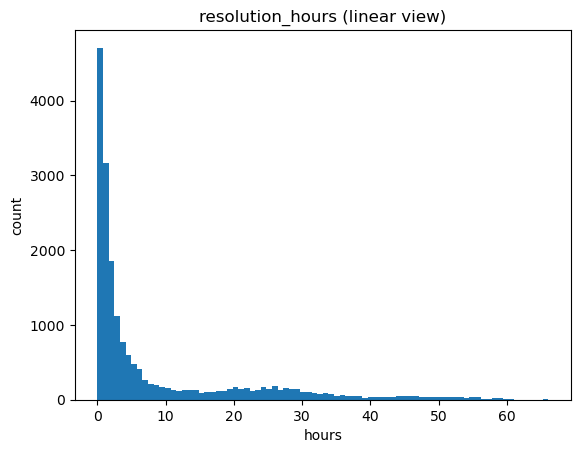

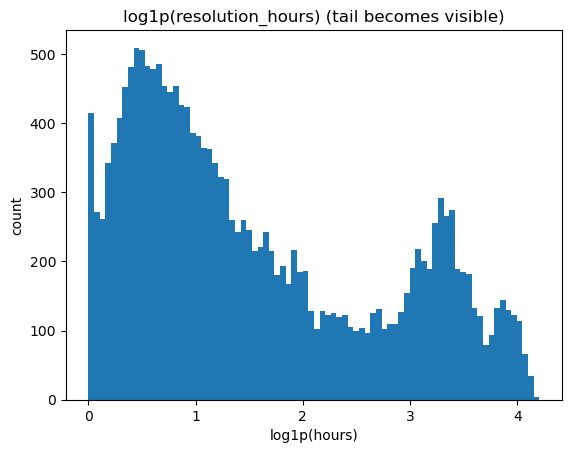

In [7]:
plt.figure()
plt.hist(y, bins=80)
plt.title("resolution_hours (linear view)")
plt.xlabel("hours")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(np.log1p(y), bins=80)
plt.title("log1p(resolution_hours) (tail becomes visible)")
plt.xlabel("log1p(hours)")
plt.ylabel("count")
plt.show()

## 3C.3 Correlation Scan

A correlation scan is a search procedure. If you search across many features, you will always "fin something". So we will:
* Restrict to numeric columns
* Exclude obvious leakage / post-outcome fields
* Treat the top correlations as **hypotheses**, not conclusions.

We will compute simple **Pearson** correlations as a first pass. The goal is triage: "what should I look at next?"

In [8]:
def suspect_leakage_columns(columns: list[str]) -> list[str]:
    suspects = []
    bad_tokens = [
        "closed", "resolution", "status", "completed", "completion",
        "duration", "elapsed", "time_to", "ttr", "sla",
        "work_order", "inspection", "final", "outcome"
    ]
    for c in columns:
        cl = c.lower()
        if any(tok in cl for tok in bad_tokens):
            suspects.append(c)
    return suspects

LEAKY_NAMES = set(suspect_leakage_columns(list(dfc.columns)))
# Always exclude the target itself and obvious IDs
LEAKY_NAMES |= set(["resolution_hours", "is_slow_p95"])
ID_LIKE = [c for c in dfc.columns if c.lower() in ["unique_key", "id", "sr_number", "request_id"]]
LEAKY_NAMES |= set(ID_LIKE)

# Numeric candidates
num_cols = [c for c in dfc.columns if pd.api.types.is_numeric_dtype(dfc[c])]
cand_cols = [c for c in num_cols if c not in LEAKY_NAMES]

print("Numeric cols:", len(num_cols))
print("Candidate numeric cols (after exclusions):", len(cand_cols))

# Show the leakage-suspect columns that exist
print("\nLeakage-suspect columns found (name-based heuristic):")
print(sorted(list(LEAKY_NAMES))[:40], "..." if len(LEAKY_NAMES) > 40 else "")

Numeric cols: 19
Candidate numeric cols (after exclusions): 11

Leakage-suspect columns found (name-based heuristic):
['agency_closed_rate', 'agency_median_resolution', 'closed_rate', 'is_closed', 'is_slow_p95', 'median_resolution_hours', 'resolution_hours', 'status', 'unique_key'] 


In [9]:
def correlation_scan(df: pd.DataFrame, y_col: str, cols: list[str]) -> pd.DataFrame:
    out = []
    y = df[y_col].astype(float)
    y_std = (y - y.mean()) / y.std(ddof=0)

    for c in cols:
        x = df[c]
        # skip near-constant columns
        if x.nunique(dropna=True) <= 2:
            continue
        # align, drop missing
        tmp = pd.DataFrame({"x": x, "y": y}).dropna()
        if len(tmp) < 200:
            continue
        # Pearson correlation
        corr = tmp["x"].corr(tmp["y"])
        out.append({"feature": c, "corr": float(corr), "n": int(len(tmp))})

    res = pd.DataFrame(out).sort_values("corr", key=lambda s: s.abs(), ascending=False)
    return res

corr_tbl = correlation_scan(dfc, "resolution_hours", cand_cols)
corr_tbl.head(15)


,feature,corr,n
4,agency_n_requests,0.384238,18894
1,dayofweek,-0.347171,18894
5,created_dow,-0.347171,18894
3,n_requests,0.226313,18894
0,created_hour,-0.047201,18894
2,street_number,0.047167,17556


### Sanity check: Correlations are Summaries, not Explanations

Pick the top correlation and look at the plot. If the plot looks like "two clusters" or "a curved pattern," the correlation is telling you almost nothing about mechanism.

Top feature by |corr|: agency_n_requests
             feature      corr      n
4  agency_n_requests  0.384238  18894
1          dayofweek -0.347171  18894
5        created_dow -0.347171  18894
3         n_requests  0.226313  18894
0       created_hour -0.047201  18894
2      street_number  0.047167  17556


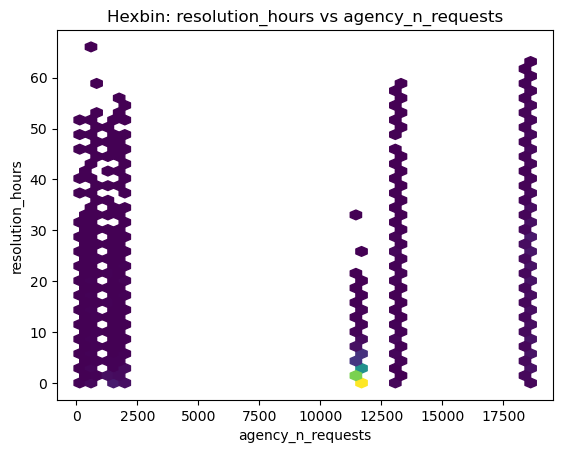

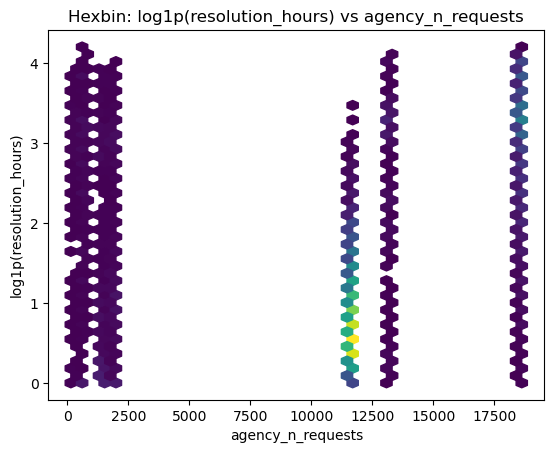

In [10]:
# Pick one feature to inspect (you can change this)
if len(corr_tbl) == 0:
    raise ValueError("No correlation results. Check that you have numeric candidate columns.")

top_feature = corr_tbl.iloc[0]["feature"]
print("Top feature by |corr|:", top_feature)
print(corr_tbl.head(8))

tmp = dfc[[top_feature, "resolution_hours"]].dropna()

plt.figure()
plt.hexbin(tmp[top_feature], tmp["resolution_hours"], gridsize=40, mincnt=1)
plt.title(f"Hexbin: resolution_hours vs {top_feature}")
plt.xlabel(top_feature)
plt.ylabel("resolution_hours")
plt.show()

plt.figure()
plt.hexbin(tmp[top_feature], np.log1p(tmp["resolution_hours"]), gridsize=40, mincnt=1)
plt.title(f"Hexbin: log1p(resolution_hours) vs {top_feature}")
plt.xlabel(top_feature)
plt.ylabel("log1p(resolution_hours)")
plt.show()


## 3C.4 Spurious Check: Do Correlations Survive a Time Split?

If a correlation is "real" (or at least stable), it should usually appear in multiple time windows. If it only appears in one window, it might be:
* a fluke (multiple comparisons)
* a process change
* a logging change
* a shift in complaint mix

We will compute correlation tables in two different time windows and compare the rankings

Numeric feature candidates: 11

Time column: created_date
Early rows: 25,000 | Late rows: 25,000

=== Spurious check: early vs late ===
Top-10 overlap: 10/10 = 100.0%

Top-10 (early)


/home/glake/miniconda3/envs/ml/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/home/glake/miniconda3/envs/ml/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


,corr
agency_n_requests,0.579121
street_number,0.137764
kw_noise,-0.129953
dayofweek,-0.093811
created_dow,-0.093811
n_requests,0.093811
kw_water,-0.065860
kw_rodent,-0.032552
created_hour,-0.021949
zip_missing,0.015162



Top-10 (late)


,corr
agency_n_requests,0.476962
dayofweek,-0.207864
created_dow,-0.207864
n_requests,0.207864
kw_rodent,-0.112309
kw_water,-0.107421
kw_noise,-0.096104
street_number,0.062590
created_hour,-0.052747
zip_missing,-0.042480


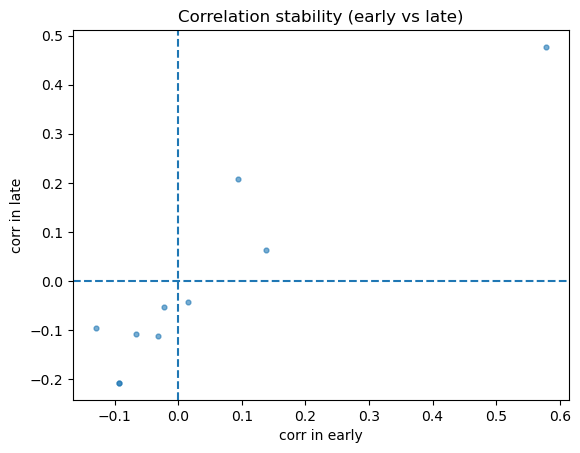


Most 'impressive' in A that shift a lot across splits (top 10):


,early,late,abs_a,abs_diff
agency_n_requests,0.579121,0.476962,0.579121,0.102160
street_number,0.137764,0.062590,0.137764,0.075174
kw_noise,-0.129953,-0.096104,0.129953,0.033849
dayofweek,-0.093811,-0.207864,0.093811,0.114053
created_dow,-0.093811,-0.207864,0.093811,0.114053
n_requests,0.093811,0.207864,0.093811,0.114053
kw_water,-0.065860,-0.107421,0.065860,0.041561
kw_rodent,-0.032552,-0.112309,0.032552,0.079757
created_hour,-0.021949,-0.052747,0.021949,0.030799
zip_missing,0.015162,-0.042480,0.015162,0.057642



Resample split sizes: A=25,000, B=25,000

=== Spurious check: resample_A vs resample_B ===
Top-10 overlap: 10/10 = 100.0%

Top-10 (resample_A)


/home/glake/miniconda3/envs/ml/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/home/glake/miniconda3/envs/ml/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


,corr
agency_n_requests,0.545656
dayofweek,-0.257629
created_dow,-0.257629
n_requests,0.257629
kw_noise,-0.103603
street_number,0.101921
kw_rodent,-0.076560
created_hour,-0.072216
kw_water,-0.065163
zip_missing,-0.019096



Top-10 (resample_B)


,corr
agency_n_requests,0.536465
dayofweek,-0.281370
created_dow,-0.281370
n_requests,0.281370
street_number,0.128720
kw_noise,-0.106874
kw_water,-0.091666
created_hour,-0.073532
kw_rodent,-0.045186
zip_missing,-0.002574


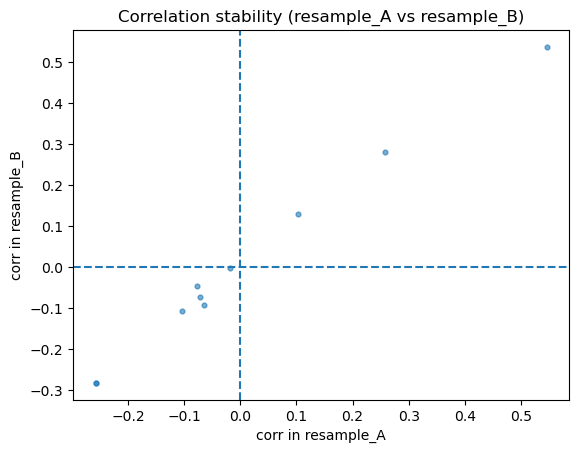


Most 'impressive' in A that shift a lot across splits (top 10):


,resample_A,resample_B,abs_a,abs_diff
agency_n_requests,0.545656,0.536465,0.545656,0.009191
dayofweek,-0.257629,-0.281370,0.257629,0.023741
created_dow,-0.257629,-0.281370,0.257629,0.023741
n_requests,0.257629,0.281370,0.257629,0.023741
kw_noise,-0.103603,-0.106874,0.103603,0.003271
street_number,0.101921,0.128720,0.101921,0.026799
kw_rodent,-0.076560,-0.045186,0.076560,0.031374
created_hour,-0.072216,-0.073532,0.072216,0.001316
kw_water,-0.065163,-0.091666,0.065163,0.026503
zip_missing,-0.019096,-0.002574,0.019096,0.016521



Interpretation guidance:
- Low overlap or wildly shifting correlations = classic spurious discovery / instability.
- Treat these correlations as hypotheses, not truths.
- Next: stratify by agency / complaint_type and check if relationships persist within strata.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_correlations(df: pd.DataFrame, y_col: str, feature_cols, method="spearman"):
    """
    Returns a Series indexed by feature col with correlation to y_col.
    Spearman is often a better default in messy EDA (monotonic + robust-ish).
    """
    use = df[[y_col] + list(feature_cols)].copy()

    # drop rows where y is missing; keep feature missingness as-is (corr will drop pairwise)
    use = use.dropna(subset=[y_col])

    corrs = {}
    for c in feature_cols:
        s = use[[y_col, c]].dropna()
        if len(s) < 30:  # avoid nonsense correlations on tiny samples
            continue
        corrs[c] = float(s[c].corr(s[y_col], method=method))
    return pd.Series(corrs).sort_values(key=lambda s: s.abs(), ascending=False)

def summarize_split(name_a, corrs_a, name_b, corrs_b, top_k=15):
    top_a = corrs_a.head(top_k)
    top_b = corrs_b.head(top_k)

    overlap = set(top_a.index).intersection(set(top_b.index))
    overlap_pct = 100.0 * len(overlap) / top_k

    print(f"\n=== Spurious check: {name_a} vs {name_b} ===")
    print(f"Top-{top_k} overlap: {len(overlap)}/{top_k} = {overlap_pct:.1f}%")

    print(f"\nTop-{top_k} ({name_a})")
    display(top_a.to_frame("corr"))

    print(f"\nTop-{top_k} ({name_b})")
    display(top_b.to_frame("corr"))

    # Align for scatter plot
    common = corrs_a.index.intersection(corrs_b.index)
    plot_df = pd.DataFrame({
        name_a: corrs_a.loc[common],
        name_b: corrs_b.loc[common],
    })

    plt.figure()
    plt.scatter(plot_df[name_a], plot_df[name_b], s=12, alpha=0.6)
    plt.axhline(0, linestyle="--")
    plt.axvline(0, linestyle="--")
    plt.title(f"Correlation stability ({name_a} vs {name_b})")
    plt.xlabel(f"corr in {name_a}")
    plt.ylabel(f"corr in {name_b}")
    plt.show()

    # Highlight most unstable among the most “impressive” features in A
    unstable = (
        plot_df.assign(abs_a=lambda d: d[name_a].abs(),
                       abs_diff=lambda d: (d[name_a] - d[name_b]).abs())
              .sort_values(["abs_a", "abs_diff"], ascending=[False, False])
              .head(10)
    )
    print("\nMost 'impressive' in A that shift a lot across splits (top 10):")
    display(unstable)

# -----------------------------
# CONFIG
# -----------------------------
y_col = "resolution_hours"  
print("Numeric feature candidates:", len(cand_cols))

# -----------------------------
# 1) TIME SPLIT STABILITY CHECK
# -----------------------------
time_col = "created_date"
df_time = df.copy()

if time_col is not None:
    df_time[time_col] = pd.to_datetime(df_time[time_col], errors="coerce")
    df_time = df_time.dropna(subset=[time_col]).sort_values(time_col)

    # Split at median timestamp (first half vs second half)
    cutoff = df_time[time_col].quantile(0.5)
    df_early = df_time[df_time[time_col] <= cutoff]
    df_late  = df_time[df_time[time_col] > cutoff]

    print(f"\nTime column: {time_col}")
    print(f"Early rows: {len(df_early):,} | Late rows: {len(df_late):,}")
else:
    # Fallback: row-order split (still useful for "would this change if data were slightly different?")
    df_time = df_time.reset_index(drop=True)
    mid = len(df_time) // 2
    df_early = df_time.iloc[:mid]
    df_late  = df_time.iloc[mid:]
    print("\nNo obvious time column found; using row-order split.")
    print(f"First half rows: {len(df_early):,} | Second half rows: {len(df_late):,}")

corrs_early = compute_correlations(df_early, y_col=y_col, feature_cols=cand_cols, method="spearman")
corrs_late  = compute_correlations(df_late,  y_col=y_col, feature_cols=cand_cols, method="spearman")

summarize_split("early", corrs_early, "late", corrs_late, top_k=10)

# ---------------------------------
# 2) RESAMPLE SPLIT (SAMPLING NOISE)
# ---------------------------------
rng = np.random.default_rng(123)
idx = np.arange(len(df))
rng.shuffle(idx)

half = len(idx) // 2
df_a = df.iloc[idx[:half]]
df_b = df.iloc[idx[half:]]

print(f"\nResample split sizes: A={len(df_a):,}, B={len(df_b):,}")

corrs_a = compute_correlations(df_a, y_col=y_col, feature_cols=cand_cols, method="spearman")
corrs_b = compute_correlations(df_b, y_col=y_col, feature_cols=cand_cols, method="spearman")

summarize_split("resample_A", corrs_a, "resample_B", corrs_b, top_k=10)

print("\nInterpretation guidance:")
print("- Low overlap or wildly shifting correlations = classic spurious discovery / instability.")
print("- Treat these correlations as hypotheses, not truths.")
print("- Next: stratify by agency / complaint_type and check if relationships persist within strata.")


## 3C.5 Condfounding Check: Stratify By the Likely Confounders

NYC 311 is full of confounders. Two of the biggest:
* `agency`
* `compaint_type`

In [12]:
# Note: this choice of feature and strat will be used again in the next several cells

# Choose a candidate feature to test for confounding
feature = top_feature  # change if you want
# feature = "agency_n_requests"     # -- see lots of NaNs
# feature = "is_weekend"      # No NaNs as it varies across the agency, complaint, and borough strata
print("Feature:", feature)

# Choose a stratifier (use whichever exists)
strat_options = [c for c in ["agency", "complaint_topk", "borough_norm"] if c in dfc.columns]
print("Available stratifiers:", strat_options)

if not strat_options:
    raise ValueError("No stratifiers found (agency/complaint_type/borough). Check your columns.")

strat = strat_options[0]  # default to first available -- TRY OTHER STRATIFIERS
print("Using stratifier:", strat)

# Top groups by count to avoid tiny strata
top_groups = (
    dfc[strat].astype(str).value_counts().head(12).index.tolist()
)

rows = []
for g in top_groups:
    d = dfc[dfc[strat].astype(str) == g][[feature, "resolution_hours"]].dropna()
    if len(d) < 300:
        continue
    corr = d[feature].corr(d["resolution_hours"])
    rows.append({"group": g, "n": len(d), "corr": float(corr)})

within = pd.DataFrame(rows).sort_values("corr", key=lambda s: s.abs(), ascending=False)
within


Feature: agency_n_requests
Available stratifiers: ['agency', 'complaint_topk', 'borough_norm']
Using stratifier: agency


/home/glake/miniconda3/envs/ml/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/glake/miniconda3/envs/ml/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/glake/miniconda3/envs/ml/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/glake/miniconda3/envs/ml/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/glake/miniconda3/envs/ml/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3023: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/glake/miniconda3/envs/ml/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3024: RuntimeWarning: invalid value e

,group,n,corr
0,NYPD,11440,NaN
1,HPD,4458,NaN
2,DSNY,794,NaN
3,DOT,755,NaN
4,DEP,711,NaN


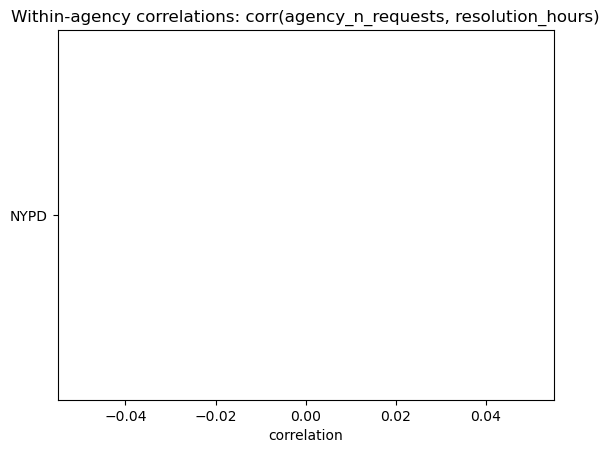

Overall corr: 0.3842384488173163


In [13]:
# Plot within-group correlations
if len(within) > 0:
    plt.figure()
    plt.barh(within["group"], within["corr"])
    plt.title(f"Within-{strat} correlations: corr({feature}, resolution_hours)")
    plt.xlabel("correlation")
    plt.gca().invert_yaxis()
    plt.show()

# Also: show overall for comparison
overall_corr = dfc[[feature, "resolution_hours"]].dropna()[feature].corr(dfc[[feature, "resolution_hours"]].dropna()["resolution_hours"])
print("Overall corr:", float(overall_corr))


### A visual stratification check  

If correlations differ by group, looking at "overall" can be misleading. Lets plot the relationship by group for a few top strata to see whether the pattern is consistent

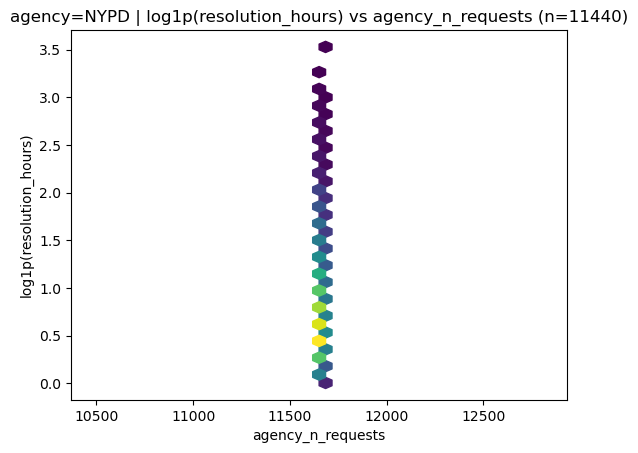

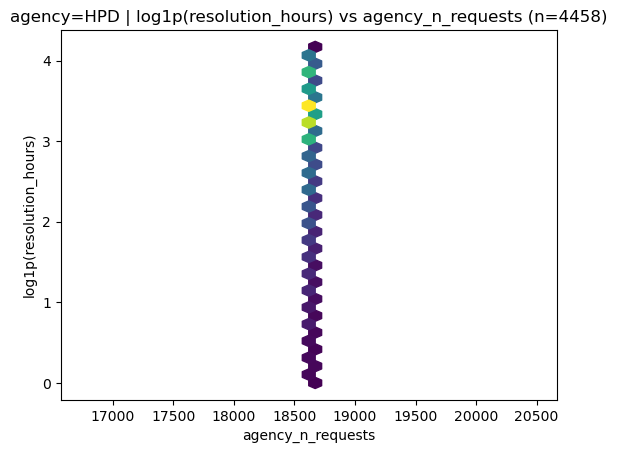

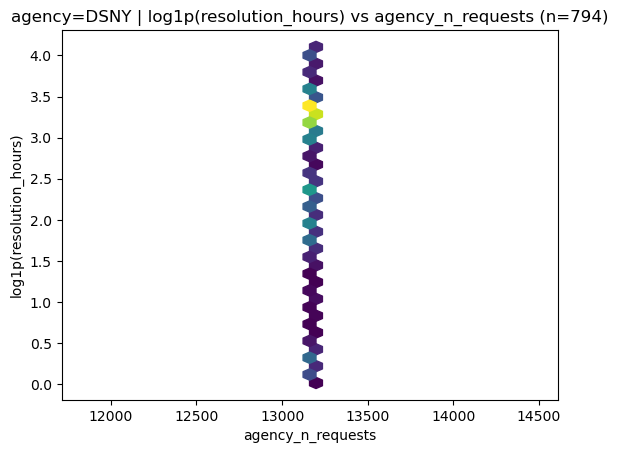

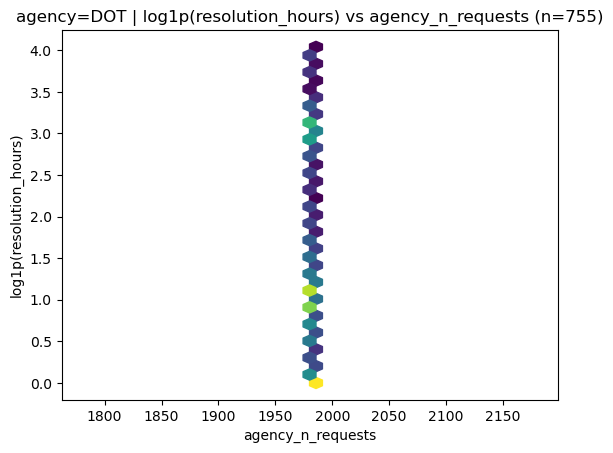

In [14]:
# Small multiple scatter/hexbin for a few groups
groups_to_plot = within["group"].head(4).tolist() if len(within) >= 4 else top_groups[:4]

for g in groups_to_plot:
    d = dfc[dfc[strat].astype(str) == g][[feature, "resolution_hours"]].dropna()
    if len(d) < 200:
        continue
    plt.figure()
    plt.hexbin(d[feature], np.log1p(d["resolution_hours"]), gridsize=35, mincnt=1)
    plt.title(f"{strat}={g} | log1p(resolution_hours) vs {feature} (n={len(d)})")
    plt.xlabel(feature)
    plt.ylabel("log1p(resolution_hours)")
    plt.show()

## 3C.6 Time-order/Leakage Hygiene

A strong correlation can be "real" and still be useless, because it uses information that would not be available at prediction time.  

**Rule:**  
A feature must be available at the time you would make the prediction

In [15]:
# Name-based audit: columns that might be post-outcome
all_cols = list(dfc.columns)
suspects = suspect_leakage_columns(all_cols)

print("Leakage suspects (heuristic, not perfect):")
for c in sorted(suspects)[:60]:
    print(" -", c)
print("... total:", len(suspects))

Leakage suspects (heuristic, not perfect):
 - agency_closed_rate
 - agency_median_resolution
 - closed_rate
 - is_closed
 - median_resolution_hours
 - resolution_hours
 - status
... total: 7


In [16]:
# Demonstration: compare correlation scan WITH and WITHOUT leakage-suspect columns (name-based)
num_cols_all = [c for c in dfc.columns if pd.api.types.is_numeric_dtype(dfc[c]) and c not in ID_LIKE]

corr_all = correlation_scan(dfc, "resolution_hours", [c for c in num_cols_all if c != "resolution_hours"])
corr_safe = corr_tbl  # from earlier (already excluded suspects)

print("Top 10 correlations (all numeric, includes possible leakage):")
print(corr_all.head(10).to_string(index=False))

print("\nTop 10 correlations (candidate set, leakage-reduced):")
print(corr_safe.head(10).to_string(index=False))

print("\nIf 'all numeric' yields dramatically stronger correlations, inspect the top features for leakage.")



Top 10 correlations (all numeric, includes possible leakage):
                 feature      corr     n
agency_median_resolution  0.711858 18894
      agency_closed_rate -0.674255 18894
       agency_n_requests  0.384238 18894
               dayofweek -0.347171 18894
             created_dow -0.347171 18894
 median_resolution_hours  0.346084 18894
             closed_rate  0.280511 18894
              n_requests  0.226313 18894
            created_hour -0.047201 18894
           street_number  0.047167 17556

Top 10 correlations (candidate set, leakage-reduced):
          feature      corr     n
agency_n_requests  0.384238 18894
        dayofweek -0.347171 18894
      created_dow -0.347171 18894
       n_requests  0.226313 18894
     created_hour -0.047201 18894
    street_number  0.047167 17556

If 'all numeric' yields dramatically stronger correlations, inspect the top features for leakage.


## 3C.7 Deliverable: Correlation &rarr; Confounder &rarr; Next Test Memo

Write a short memo with **three** items. Each item should be structured like this:  
1. **Observed correlation/association:** what did you see (feature + direction + metric)?
2. **Most plausible confounder**: name it concretely (agency, complaint type, borough, time, selection bias, logging change)
3. **Next test:** one fast plot/table that would reduce self-deception (stratify, time split, negative control, etc.)

### Memo  
**Correlation #1:**  
* Feature: `agency_n_requets`
* Direction/sign: Positive (moderate), `r = +0.38`
* Evidence (overall corr, plot, time window): 
  * Correlation scan ranks this as the largest by `r` on the analysis slice
  * Hexbin of `resolution_hours` vs `agency_n_requests` showhs higher typical resolution times for agencies with larger request counts, but in discrete vertical bankds, indicating group differences rather than a smooth within-group trend.
* Plausible confounder:
* Next test:

**Correlation #2:**  
* Feature:
* Direction/sign:
* Evidence (overall corr, plot, time window):
* Plausible confounder:
* Next test:

**Correlation #3:**  
* Feature:
* Direction/sign:
* Evidence (overall corr, plot, time window):
* Plausible confounder:
* Next test

# 3.D Hypothesis Generation (NYC 311)  

EDA is not "find answers". It is generate testable hypotheses.  

This module will: 
* Start from what we seen in 3.A - 3.C (distributions, group differences, correlations, confounders)
* Write 8-12 hypothesis entries using a strict template
  **observation &rarr; hypothesis &rarr; prediction &rarr; confounder &rarr; next check**
* Force specifity: name the metric(median/p95/rate), the grouping(agency/complaint_type/borough/time), and the direction
* Include artifacts: at least 2 hypotheses about measurement/logging/censoring/missingness
* Prioritize: score each hypothesis by impact and falsifiability and pick top 3
* Deliverable: a one-page EDA Hypothesis Memo (top 3 hypotheses + next plot/test for each)

**Rule:**
If you can't say what result would falsify it, it is not a hypothesis yet

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 160)
pd.set_option("display.width", 160)

## 3D.1 Load the Normalized NYC 311 Table (same artifacts as 3.A - 3.C)

We will load the normalized cache written by Module 3.A.

In [2]:
# Prefer the normalized cache written by Module 3.A
M3_DATA_DIR = Path("work/m3/data")
NORM_PATH = M3_DATA_DIR / "nyc311_features_norm.parquet"

print("Normalized cache:", NORM_PATH, "| exists?", NORM_PATH.exists())

Normalized cache: work/m3/data/nyc311_features_norm.parquet | exists? True


In [3]:
def load_normalized() -> pd.DataFrame:
    # 1) Preferred: normalized cache from 3.A
    if NORM_PATH.exists():
        df = pd.read_parquet(NORM_PATH)
        df["_source"] = "3.A_normalized_cache"
        return df

    raise FileNotFoundError(
        "No normalized table found. Run Module 3.A first."
    )
    
df = load_normalized()
print("Loaded:", df["_source"].iloc[0] if "_source" in df.columns else "unknown")
print("Shape:", df.shape)
df.head(5)

Loaded: 3.A_normalized_cache
Shape: (50000, 25)


,unique_key,created_date,created_day,created_hour,dayofweek,is_weekend,agency,borough_norm,complaint_topk,zip_missing,kw_noise,kw_rodent,kw_water,street_number,n_requests,closed_rate,median_resolution_hours,agency_n_requests,agency_closed_rate,agency_median_resolution,status,is_closed,resolution_hours,_source,created_dow
0,67720523,2026-01-30 01:51:21,2026-01-30,1,4,0,NYPD,<NA>,other,1,1,0,0,<NA>,280,0.435714,0.480972,11651,0.981890,1.277778,Unspecified,0,NaN,3.A_normalized_cache,4
1,67746090,2026-01-30 01:51:04,2026-01-30,1,4,0,DOE,BROOKLYN,other,0,0,0,0,911,280,0.435714,0.480972,144,0.520833,7.605000,In Progress,0,NaN,3.A_normalized_cache,4
2,67758820,2026-01-30 01:50:53,2026-01-30,1,4,0,NYPD,MANHATTAN,noise - residential,0,1,0,0,936,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,3.A_normalized_cache,4
3,67707975,2026-01-30 01:50:52,2026-01-30,1,4,0,NYPD,STATEN ISLAND,noise - residential,0,1,0,0,190,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,3.A_normalized_cache,4
4,67771794,2026-01-30 01:50:32,2026-01-30,1,4,0,TLC,QUEENS,other,0,0,0,0,<NA>,280,0.435714,0.480972,246,0.117886,16.582778,In Progress,0,NaN,3.A_normalized_cache,4


## 3D.2 Quick Recap Artifacts You Can Use As "Observations"

Your hypotheses must start from an observation. Below are a few common observation generators:  
* outcome distribution (median vs p95)
* group differences (agency/complaint_type/borough)
* missingness rates (measurement artifacts)
* time slices (stability/drift)

Use these to seed hypotheses

In [6]:
# Analysis slice: closed cases with non-negative resolution
df2 = df.copy()

if "is_closed" in df2.columns:
    is_closed = df2["is_closed"] == 1
elif "status" in df2.columns:
    is_closed = df2["status"].isin(["CLOSED", "RESOLVED"])
else:
    is_closed = pd.Series([True]*len(df2))

if "resolution_hours" not in df2.columns:
    raise ValueError("resolution_hours not found; Check Module 2 artifacts and parsing")

mask = is_closed & df2["resolution_hours"].notna() & np.isfinite(df2["resolution_hours"])
dfc = df2.loc[mask].copy()
y = dfc["resolution_hours"].astype(float)

print("Rows (raw):", len(df2))
print("Rows (analysis slice):", len(dfc))
print(y.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

Rows (raw): 50000
Rows (analysis slice): 18894
count    18894.000000
mean         8.827548
std         12.997412
min          0.000000
50%          2.318889
90%         28.556333
95%         38.251319
99%         54.333253
max         66.066389
Name: resolution_hours, dtype: float64


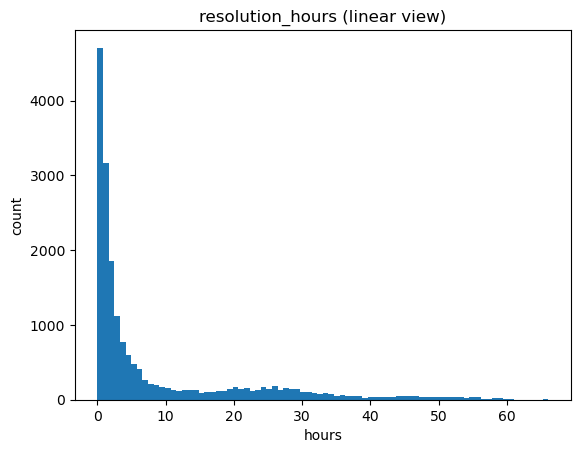

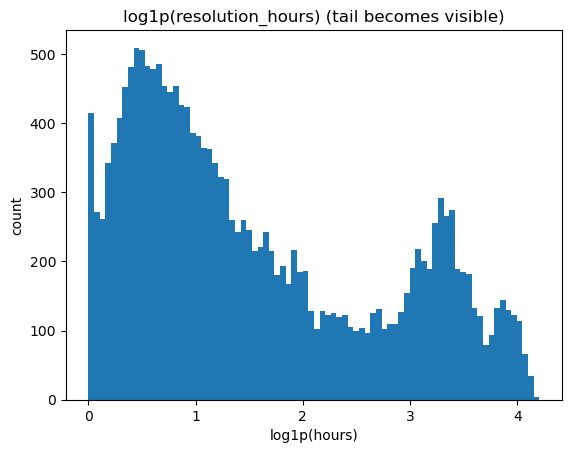

In [7]:
# Outcome plots (use these as observation sources)
plt.figure()
plt.hist(y, bins=80)
plt.title("resolution_hours (linear view)")
plt.xlabel("hours")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(np.log1p(y), bins=80)
plt.title("log1p(resolution_hours) (tail becomes visible)")
plt.xlabel("log1p(hours)")
plt.ylabel("count")
plt.show()

In [8]:
def group_summary(df: pd.DataFrame, group_col: str, y_col: str = "resolution_hours", top_k: int = 12) -> pd.DataFrame:
    d = df[[group_col, y_col]].dropna().copy()
    d[group_col] = d[group_col].astype(str)
    g = d.groupby(group_col)[y_col]
    out = pd.DataFrame({
        "n": g.size(),
        "median": g.median(),
        "p95": g.quantile(0.95),
        "p99": g.quantile(0.99),
    }).sort_values("n", ascending=False)
    out = out[out["n"] >= 300].head(top_k)  # avoid tiny groups for first-pass hypotheses
    out["p95_minus_median"] = out["p95"] - out["median"]
    return out.sort_values("p95", ascending=False)

for col in ["agency", "complaint_type", "borough"]:
    if col in dfc.columns:
        print("\nTop groups by p95 (min n>=300):", col)
        display_tbl = group_summary(dfc, col, top_k=12)
        print(display_tbl.to_string())


Top groups by p95 (min n>=300): agency
            n     median        p95        p99  p95_minus_median
agency                                                          
HPD      4458  23.354861  52.485792  59.008550         29.130931
DSNY      794  20.099722  46.265167  57.975308         26.165444
DOT       755   2.448611  29.547472  48.556106         27.098861
DEP       711   1.033333  28.458333  46.200000         27.425000
NYPD    11440   1.278056   6.402319  12.438022          5.124264


In [9]:
# Missingness / measurement artifacts
# What percent of rows are missing in each column?
miss = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
miss.head(20)



resolution_hours            60.77
street_number                8.10
agency_median_resolution     0.37
borough_norm                 0.07
unique_key                   0.00
dayofweek                    0.00
created_date                 0.00
created_hour                 0.00
created_day                  0.00
complaint_topk               0.00
agency                       0.00
is_weekend                   0.00
zip_missing                  0.00
kw_water                     0.00
n_requests                   0.00
kw_rodent                    0.00
kw_noise                     0.00
median_resolution_hours      0.00
closed_rate                  0.00
agency_closed_rate           0.00
dtype: float64

## 3D.3 The Hypothesis Template 

This template should be used to write the hypothesis:
* **Observation:** a fact you saw in a plot/table (must name metric + group + direction)
* **Hypothesis:** a mechanism that could generate that observation
* **Prediction:** what else should be true if the hypothesis is correct (ideally a new slice/new plot)
* **Confounder:** one plausible alternative explanation (be concrete)
* **Next check:** the fastest plot/table that could reduce self-deception

#### Example (good)  
* Observation: "In the last 7 days, **agency=A** has **p95 resolution_hours**~2x higher than agency=B"
* Hypothesis: "Agency A routes these complaints to an offline workflow with batching"
* Prediction: "Within agency A, complaint types that require inspections should dominate the tail"
* Confounder: "Complaint mix differs across agencies (type confounding)"
* Next check: "Stratify by complaint_type within each agency and compare p95"

# 3D.4 Build Your Hypothesis Backlock (8-12 entries)

Fill in the table below  

**Requirements**
* 8-12 rows
* each row must include: metric + grouping + direction
* include at least 2 measurements/logging/censoring/missingness hypotheses
* keep the prediction and next check falsifiable.

In [11]:
# Edit this list to create 8–12 hypotheses.
# Tip: keep them short and precise, and force specificity:
# - name the metric (median/p95/rate)
# - name the grouping (agency/type/borough/time)
# - name the direction (higher/lower/increasing/decreasing)
#
# Ratings are 1–5:
# - impact:            If true, how important is this for decisions/modeling?
# - falsifiable:       How easy is it to disprove quickly with the data/plots we have?
# - robust:            Would the claim likely hold across time windows / reasonable slices?
# - cost:              How cheap is the next check? (Higher = cheaper/easier)
#
# Scoring: weighted sum (defaults emphasize impact + falsifiability, as in the micro-lab).

hypotheses = [
    {
        "id": "H1",
        "observation": "Agency-level tail risk differs: some agencies show much higher p95 resolution_hours (last 7 days).",
        "hypothesis": "Those agency gaps are mostly complaint-type mix (composition), not agency process differences.",
        "prediction": "After conditioning on complaint_type, agency p95 gaps will shrink substantially within strata.",
        "confounder": "Within-type severity still differs by location/season/time (hidden subtypes).",
        "next_check": "Stratify by complaint_type: compute agency p95 within each type; compare spread of agency p95 before vs after conditioning.",
        "impact": 4,
        "falsifiable": 5,
        "robust": 4,
        "cost": 5,
    },
    {
        "id": "H2",
        "observation": "The extreme tail (p99) is far above the median; a small number of cases dominate the tail mass.",
        "hypothesis": "A small subset of complaint types drive most p99 tail events (rare but operationally important).",
        "prediction": "Top ~5 complaint types will account for a large fraction of p99 cases and long-duration outliers.",
        "confounder": "Some outliers may be timestamp/data-entry errors rather than true delays.",
        "next_check": "List complaint types ranked by p99 and by count of cases above the global p99 threshold; inspect a few raw examples for plausibility.",
        "impact": 4,
        "falsifiable": 5,
        "robust": 4,
        "cost": 4,
    },
    {
        "id": "H3",
        "observation": "Resolution time distribution shows suspicious spikes/round numbers or impossible values (e.g., 0 or extremely large).",
        "hypothesis": "A portion of extreme cases are data quality errors (impossible timestamps) rather than true operational delays.",
        "prediction": "Outliers will cluster around invalid timestamp patterns (closed_date < created_date, missing timezone parsing, default dates).",
        "confounder": "Some true cases can be legitimately long-running (e.g., investigations), so long duration alone isn’t an error.",
        "next_check": "Audit timestamp validity: count closed_date < created_date; inspect top 50 resolution_hours rows; check for parsing/missing patterns by agency/type.",
        "impact": 5,
        "falsifiable": 4,
        "robust": 4,
        "cost": 4,
    },
    {
        "id": "H4",
        "observation": "Missing closed_date / status differs by agency and complaint_type (missingness is not uniform).",
        "hypothesis": "Some missingness is a logging/ETL artifact: certain workflows drop closure fields during ingestion.",
        "prediction": "Missingness will spike around specific times or be concentrated in specific agencies/types beyond what open-case rates explain.",
        "confounder": "Censoring: those agencies/types may genuinely have more open cases at snapshot time (not a logging bug).",
        "next_check": "Compare open/closed rates by agency/type; plot missing closed_date rate by day; look for step-changes or isolated spikes.",
        "impact": 5,
        "falsifiable": 4,
        "robust": 3,
        "cost": 4,
    },
    {
        "id": "H5",
        "observation": "Daily volume varies strongly by day-of-week; median/p95 resolution_hours appears to shift with weekday.",
        "hypothesis": "Day-of-week effects reflect staffing/queue dynamics (not per-case complexity): backlog accumulates on weekends and resolves after.",
        "prediction": "Cases created on Fri/Sat/Sun will show higher p95 resolution_hours than Mon/Tue, even within the same agency/type.",
        "confounder": "Complaint mix differs by weekday (different types arrive on weekends).",
        "next_check": "Within a single agency + complaint_type, compare p95 by created_dow; repeat for a few high-volume strata.",
        "impact": 3,
        "falsifiable": 4,
        "robust": 3,
        "cost": 4,
    },
    {
        "id": "H6",
        "observation": "Borough-level differences appear in median/p95 resolution_hours (some boroughs look slower).",
        "hypothesis": "Borough is a proxy for case complexity and/or operational constraints; it explains tail risk beyond agency/type.",
        "prediction": "Within a fixed agency + complaint_type, p95 will still differ by borough (persistent gap).",
        "confounder": "Borough correlates with unobserved subtypes (e.g., building type, neighborhood, severity) and volume spikes.",
        "next_check": "Compute p95 by borough within (agency, complaint_type) strata; focus on top strata by count; visualize with a small multiples table/plot.",
        "impact": 3,
        "falsifiable": 4,
        "robust": 3,
        "cost": 5,
    },
    {
        "id": "H7",
        "observation": "Top correlations against resolution_hours change noticeably across different slices/time windows.",
        "hypothesis": "Many 'top' correlations are unstable (feature fishing / multiple comparisons) rather than consistent signals.",
        "prediction": "Rank correlation tables in two splits (first half vs second half of the week) will show low overlap in top-k features.",
        "confounder": "A real process change or a volume composition shift happened within the week.",
        "next_check": "Compute top-k correlations in two splits; measure overlap and rank correlation; identify features that remain top across both splits.",
        "impact": 4,
        "falsifiable": 5,
        "robust": 4,
        "cost": 5,
    },
    {
        "id": "H8",
        "observation": "The distribution of resolution_hours (or missingness) shows a step-change around a specific day/time in the week.",
        "hypothesis": "A logging/measurement change (schema, parsing, pipeline) occurred mid-week and altered recorded resolution behavior.",
        "prediction": "Multiple fields will shift together (missingness, value ranges, volume) at the same boundary, not just resolution_hours.",
        "confounder": "A real external event (weather, outage, policy shift) changed the underlying process, not logging.",
        "next_check": "Plot key field missingness + volume + median/p95 resolution_hours by day; look for coordinated discontinuities; verify in raw fields if available.",
        "impact": 5,
        "falsifiable": 4,
        "robust": 3,
        "cost": 4,
    },
    {
        "id": "H9",
        "observation": "A small number of agencies/types account for a disproportionate share of 'slow' cases (above p95 threshold).",
        "hypothesis": "Slow-case concentration is driven by a few operationally complex categories, not broad underperformance.",
        "prediction": "The slow-case rate will be sharply higher in those agencies/types and stable under resampling/time split.",
        "confounder": "Selection bias: only closed cases are measured; long-running open cases are missing (censoring).",
        "next_check": "Compute slow-rate (>= global p95) by agency/type; repeat in two time splits; compare overlap of top contributors.",
        "impact": 4,
        "falsifiable": 4,
        "robust": 4,
        "cost": 5,
    },
    {
        "id": "H10",
        "observation": "Some complaint types show bimodal resolution behavior (fast majority + slow minority tail).",
        "hypothesis": "Those types represent a mixture of two subprocesses (simple vs escalated workflow) with different resolution dynamics.",
        "prediction": "Within a single complaint_type, stratifying by a proxy (agency, borough, created_hour, or descriptor if available) will separate the two modes.",
        "confounder": "Bimodality may be an artifact of missing/rounded timestamps or batched closures.",
        "next_check": "Plot resolution_hours distribution for the complaint_type; stratify by candidate proxies (agency/borough/created_dow) and re-plot to see if modes separate.",
        "impact": 3,
        "falsifiable": 4,
        "robust": 3,
        "cost": 4,
    },
    {
        "id": "H11",
        "observation": "Median resolution time differs dramatically by agency (e.g., NYPD very fast, HPD very slow)",
        "hypothesis":  "Resolution time is primarily determined by the type of work each agency performs",
        "prediction":  "Within a single agency, the variance of resolution time will be much smaller than the full dataset",
        "confounder":  "Complaint type mix inside each agency",
        "next_check":  "Compute resolution-time spread (IQR or p95) per agency and compare to global spread",
        "impact": 5,
        "falsifiable": 5,
        "robust": 5,
        "cost": 5,
    },
    {
        "id": "H12",
        "observation": "Heat/Hot Water and similar categories have very high p50 and p95 compared to noise or parking",
        "hypothesis":  "Long resolution times are caused by complaint types that require multi-step or physical interventions",
        "prediction":  "Most cases above the global p95 threshold will belong to a small number of complaint types",
        "confounder":  "These complaint types are mostly handled by one agency",
        "next_check":  "Look at the complaint-type distribution for only the slow (>= p95) cases",
        "impact": 5,
        "falsifiable": 5,
        "robust": 4,
        "cost": 5,
    },
    {
        "id": "H13",
        "observation": "Days with more requests have higher median resolution time",
        "hypothesis":  "System congestion increases resolution time.",
        "prediction":  "Within high-volume days, the entire distribution (not just the tail) shifts upward",
        "confounder":  "The high-volume day has a different agency or complaint mix",
        "next_check":  "Compare per-agency median resolution on high- vs low-volume days",
        "impact": 4,
        "falsifiable": 4,
        "robust": 2,
        "cost": 3,
    }
]

hyp_df = pd.DataFrame(hypotheses)

# Weighted score (defaults from the webpage micro-lab)
WEIGHTS = {"impact": 0.35, "falsifiable": 0.35, "robust": 0.20, "cost": 0.10}

for k in WEIGHTS:
    hyp_df[k] = hyp_df[k].astype(float)

hyp_df["priority_score"] = (
    WEIGHTS["impact"] * hyp_df["impact"]
    + WEIGHTS["falsifiable"] * hyp_df["falsifiable"]
    + WEIGHTS["robust"] * hyp_df["robust"]
    + WEIGHTS["cost"] * hyp_df["cost"]
)

hyp_df = hyp_df.sort_values("priority_score", ascending=False)

print("Weights:", WEIGHTS)
print("\nTop hypotheses (summary):")
print(hyp_df[["id", "priority_score", "impact", "falsifiable", "robust", "cost", "hypothesis"]].head(12).to_string(index=False))

print("\nTry:")
print("- Change WEIGHTS to reflect what you value (speed vs confidence vs impact).")
print("- Add 2 more hypotheses that are explicitly about logging/measurement/censoring/missingness.")
print("- Pick the top 3 and write the one-page memo with the exact next plot/test for each.")

# Show the full working table
hyp_df


Weights: {'impact': 0.35, 'falsifiable': 0.35, 'robust': 0.2, 'cost': 0.1}

Top hypotheses (summary):
 id  priority_score  impact  falsifiable  robust  cost                                                                                                                         hypothesis
H11            5.00     5.0          5.0     5.0   5.0                                                   Resolution time is primarily determined by the type of work each agency performs
H12            4.80     5.0          5.0     4.0   5.0                              Long resolution times are caused by complaint types that require multi-step or physical interventions
 H7            4.45     4.0          5.0     4.0   5.0                      Many 'top' correlations are unstable (feature fishing / multiple comparisons) rather than consistent signals.
 H1            4.45     4.0          5.0     4.0   5.0                                     Those agency gaps are mostly complaint-type mix (composition), 

,id,observation,hypothesis,prediction,confounder,next_check,impact,falsifiable,robust,cost,priority_score
10,H11,Median resolution time differs dramatically by...,Resolution time is primarily determined by the...,"Within a single agency, the variance of resolu...",Complaint type mix inside each agency,Compute resolution-time spread (IQR or p95) pe...,5.0,5.0,5.0,5.0,5.00
11,H12,Heat/Hot Water and similar categories have ver...,Long resolution times are caused by complaint ...,Most cases above the global p95 threshold will...,These complaint types are mostly handled by on...,Look at the complaint-type distribution for on...,5.0,5.0,4.0,5.0,4.80
6,H7,Top correlations against resolution_hours chan...,Many 'top' correlations are unstable (feature ...,Rank correlation tables in two splits (first h...,A real process change or a volume composition ...,Compute top-k correlations in two splits; meas...,4.0,5.0,4.0,5.0,4.45
0,H1,Agency-level tail risk differs: some agencies ...,Those agency gaps are mostly complaint-type mi...,"After conditioning on complaint_type, agency p...",Within-type severity still differs by location...,Stratify by complaint_type: compute agency p95...,4.0,5.0,4.0,5.0,4.45
1,H2,The extreme tail (p99) is far above the median...,A small subset of complaint types drive most p...,Top ~5 complaint types will account for a larg...,Some outliers may be timestamp/data-entry erro...,List complaint types ranked by p99 and by coun...,4.0,5.0,4.0,4.0,4.35
2,H3,Resolution time distribution shows suspicious ...,A portion of extreme cases are data quality er...,Outliers will cluster around invalid timestamp...,Some true cases can be legitimately long-runni...,Audit timestamp validity: count closed_date < ...,5.0,4.0,4.0,4.0,4.35
3,H4,Missing closed_date / status differs by agency...,Some missingness is a logging/ETL artifact: ce...,Missingness will spike around specific times o...,Censoring: those agencies/types may genuinely ...,Compare open/closed rates by agency/type; plot...,5.0,4.0,3.0,4.0,4.15
7,H8,The distribution of resolution_hours (or missi...,"A logging/measurement change (schema, parsing,...",Multiple fields will shift together (missingne...,"A real external event (weather, outage, policy...",Plot key field missingness + volume + median/p...,5.0,4.0,3.0,4.0,4.15
8,H9,A small number of agencies/types account for a...,Slow-case concentration is driven by a few ope...,The slow-case rate will be sharply higher in t...,Selection bias: only closed cases are measured...,Compute slow-rate (>= global p95) by agency/ty...,4.0,4.0,4.0,5.0,4.10
5,H6,Borough-level differences appear in median/p95...,Borough is a proxy for case complexity and/or ...,"Within a fixed agency + complaint_type, p95 wi...",Borough correlates with unobserved subtypes (e...,"Compute p95 by borough within (agency, complai...",3.0,4.0,3.0,5.0,3.55


## 3D.5 Prioritize - pick the top 3

Sort by **priority_score**, then sanity-check:  
* Are you double-counting the same idea? (merge duplicates)
* Are at least 2 hypotheses about measurement/logging/censoring/missingness?
* Are your next checks, actually fast (one plot/table each)

Select the top 3 to pursue

In [12]:
# Sort and inspect (uses the new 4-dimension ratings)
hyp_sorted = hyp_df.sort_values(
    ["priority_score", "impact", "falsifiable", "robust", "cost"],
    ascending=[False, False, False, False, False],
).copy()

cols = [
    "id",
    "priority_score",
    "impact",
    "falsifiable",
    "robust",
    "cost",
    "observation",
    "hypothesis",
    "prediction",
    "confounder",
    "next_check",
]

hyp_sorted[cols].head(12)


,id,priority_score,impact,falsifiable,robust,cost,observation,hypothesis,prediction,confounder,next_check
10,H11,5.00,5.0,5.0,5.0,5.0,Median resolution time differs dramatically by...,Resolution time is primarily determined by the...,"Within a single agency, the variance of resolu...",Complaint type mix inside each agency,Compute resolution-time spread (IQR or p95) pe...
11,H12,4.80,5.0,5.0,4.0,5.0,Heat/Hot Water and similar categories have ver...,Long resolution times are caused by complaint ...,Most cases above the global p95 threshold will...,These complaint types are mostly handled by on...,Look at the complaint-type distribution for on...
6,H7,4.45,4.0,5.0,4.0,5.0,Top correlations against resolution_hours chan...,Many 'top' correlations are unstable (feature ...,Rank correlation tables in two splits (first h...,A real process change or a volume composition ...,Compute top-k correlations in two splits; meas...
0,H1,4.45,4.0,5.0,4.0,5.0,Agency-level tail risk differs: some agencies ...,Those agency gaps are mostly complaint-type mi...,"After conditioning on complaint_type, agency p...",Within-type severity still differs by location...,Stratify by complaint_type: compute agency p95...
2,H3,4.35,5.0,4.0,4.0,4.0,Resolution time distribution shows suspicious ...,A portion of extreme cases are data quality er...,Outliers will cluster around invalid timestamp...,Some true cases can be legitimately long-runni...,Audit timestamp validity: count closed_date < ...
1,H2,4.35,4.0,5.0,4.0,4.0,The extreme tail (p99) is far above the median...,A small subset of complaint types drive most p...,Top ~5 complaint types will account for a larg...,Some outliers may be timestamp/data-entry erro...,List complaint types ranked by p99 and by coun...
3,H4,4.15,5.0,4.0,3.0,4.0,Missing closed_date / status differs by agency...,Some missingness is a logging/ETL artifact: ce...,Missingness will spike around specific times o...,Censoring: those agencies/types may genuinely ...,Compare open/closed rates by agency/type; plot...
7,H8,4.15,5.0,4.0,3.0,4.0,The distribution of resolution_hours (or missi...,"A logging/measurement change (schema, parsing,...",Multiple fields will shift together (missingne...,"A real external event (weather, outage, policy...",Plot key field missingness + volume + median/p...
8,H9,4.10,4.0,4.0,4.0,5.0,A small number of agencies/types account for a...,Slow-case concentration is driven by a few ope...,The slow-case rate will be sharply higher in t...,Selection bias: only closed cases are measured...,Compute slow-rate (>= global p95) by agency/ty...
5,H6,3.55,3.0,4.0,3.0,5.0,Borough-level differences appear in median/p95...,Borough is a proxy for case complexity and/or ...,"Within a fixed agency + complaint_type, p95 wi...",Borough correlates with unobserved subtypes (e...,"Compute p95 by borough within (agency, complai..."


In [14]:
# Pick your top 3 hypotheses by id (edit this list)
TOP3 = ["H11", "H12", "H7"]

top3_df = hyp_df[hyp_df["id"].isin(TOP3)].copy()

top3_df


,id,observation,hypothesis,prediction,confounder,next_check,impact,falsifiable,robust,cost,priority_score
10,H11,Median resolution time differs dramatically by...,Resolution time is primarily determined by the...,"Within a single agency, the variance of resolu...",Complaint type mix inside each agency,Compute resolution-time spread (IQR or p95) pe...,5.0,5.0,5.0,5.0,5.00
11,H12,Heat/Hot Water and similar categories have ver...,Long resolution times are caused by complaint ...,Most cases above the global p95 threshold will...,These complaint types are mostly handled by on...,Look at the complaint-type distribution for on...,5.0,5.0,4.0,5.0,4.80
6,H7,Top correlations against resolution_hours chan...,Many 'top' correlations are unstable (feature ...,Rank correlation tables in two splits (first h...,A real process change or a volume composition ...,Compute top-k correlations in two splits; meas...,4.0,5.0,4.0,5.0,4.45


## 3D.6 Deliverable: Generate a one-page EDA Hypothesis memo

In [15]:
def render_memo(df_top: pd.DataFrame, weights: dict) -> str:
    lines = []
    lines.append("# EDA Hypothesis Memo — Module 3.D (NYC 311)")
    lines.append("")
    lines.append("**Top 3 hypotheses to pursue next**")
    lines.append("")
    lines.append(
        f"_Scoring weights_: impact={weights['impact']}, "
        f"falsifiable={weights['falsifiable']}, "
        f"robust={weights['robust']}, "
        f"cost={weights['cost']}"
    )
    lines.append("")

    for _, r in df_top.iterrows():
        score_str = (
            f"{r['impact']}·impact + "
            f"{r['falsifiable']}·falsifiable + "
            f"{r['robust']}·robust + "
            f"{r['cost']}·cost = "
            f"{r['priority_score']:.2f}"
        )

        lines.append(f"## {r['id']} (priority score: {score_str})")
        lines.append(f"- **Observation:** {r['observation']}")
        lines.append(f"- **Hypothesis:** {r['hypothesis']}")
        lines.append(f"- **Prediction:** {r['prediction']}")
        lines.append(f"- **Primary confounder:** {r['confounder']}")
        lines.append(f"- **Next check (one plot / one table):** {r['next_check']}")
        lines.append("")

    lines.append("---")
    lines.append("**Notes for reviewers:**")
    lines.append("- Each hypothesis names a metric (median/p95/rate), a grouping (agency/type/borough/time), and a direction.")
    lines.append("- Confounders are concrete, not generic (composition, censoring, logging, timing).")
    lines.append("- Next checks are intentionally cheap: a single stratified plot or summary table.")
    lines.append("- If a check fails, the hypothesis should be downgraded or discarded.")

    return "\n".join(lines)


memo_md = render_memo(top3_df, WEIGHTS)
print(memo_md)

# EDA Hypothesis Memo — Module 3.D (NYC 311)

**Top 3 hypotheses to pursue next**

_Scoring weights_: impact=0.35, falsifiable=0.35, robust=0.2, cost=0.1

## H11 (priority score: 5.0·impact + 5.0·falsifiable + 5.0·robust + 5.0·cost = 5.00)
- **Observation:** Median resolution time differs dramatically by agency (e.g., NYPD very fast, HPD very slow)
- **Hypothesis:** Resolution time is primarily determined by the type of work each agency performs
- **Prediction:** Within a single agency, the variance of resolution time will be much smaller than the full dataset
- **Primary confounder:** Complaint type mix inside each agency
- **Next check (one plot / one table):** Compute resolution-time spread (IQR or p95) per agency and compare to global spread

## H12 (priority score: 5.0·impact + 5.0·falsifiable + 4.0·robust + 5.0·cost = 4.80)
- **Observation:** Heat/Hot Water and similar categories have very high p50 and p95 compared to noise or parking
- **Hypothesis:** Long resolution times are c

In [16]:
# Optional: export memo to a markdown file in your workspace
OUT_DIR = Path("work/m3/outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)
out_path = OUT_DIR / "module3_D_hypothesis_memo.md"

out_path.write_text(memo_md, encoding="utf-8")
print("Wrote:", out_path)

Wrote: work/m3/outputs/module3_D_hypothesis_memo.md


# Module 3.E Inference (intuition first) on NYC 311

This module applies Module 3 ideas to NYC 311:  
* **Sampling Variability:** estimates change across time splits. Even with the same system
* **Bootstrap Intervals:** 95% intervas for **median** and **p95** of `resolution_hours`
* **Group Uncertainity:** bootstrap the **difference in medians** and optional p95 between two groups
* **Stability Check:** does the top agency remain top under resampling.

**Deliverable:**  
1-2 plots + a short paragraph: "What I estimate" and "How uncertain I am"

In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 160)
pd.set_option("display.width", 160)

rng = np.random.default_rng(42)


## 3E.1 Load the Normalized NYC 311 table (from 3.A)

In [2]:
M3_DATA_DIR = Path("work/m3/data") 
NORM_PATH = M3_DATA_DIR / "nyc311_features_norm.parquet"

if not NORM_PATH.exists():
    raise FileNotFoundError(
        f"Missing normalized cache at {NORM_PATH}. "
        "Run Module 3.A first to create it."
    )

df = pd.read_parquet(NORM_PATH)
print("Loaded:", NORM_PATH)
print("Shape:", df.shape)
df.head(3)

Loaded: work/m3/data/nyc311_features_norm.parquet
Shape: (50000, 25)


,unique_key,created_date,created_day,created_hour,dayofweek,is_weekend,agency,borough_norm,complaint_topk,zip_missing,kw_noise,kw_rodent,kw_water,street_number,n_requests,closed_rate,median_resolution_hours,agency_n_requests,agency_closed_rate,agency_median_resolution,status,is_closed,resolution_hours,_source,created_dow
0,67720523,2026-01-30 01:51:21,2026-01-30,1,4,0,NYPD,<NA>,other,1,1,0,0,<NA>,280,0.435714,0.480972,11651,0.981890,1.277778,Unspecified,0,NaN,2.C_features_parquet,4
1,67746090,2026-01-30 01:51:04,2026-01-30,1,4,0,DOE,BROOKLYN,other,0,0,0,0,911,280,0.435714,0.480972,144,0.520833,7.605000,In Progress,0,NaN,2.C_features_parquet,4
2,67758820,2026-01-30 01:50:53,2026-01-30,1,4,0,NYPD,MANHATTAN,noise - residential,0,1,0,0,936,280,0.435714,0.480972,11651,0.981890,1.277778,In Progress,0,NaN,2.C_features_parquet,4


## 3E.2 Define the Analysis Slice and Outcome

We focus on **closed cases** with a valid non-negative `resolution_hours`.  

Uncertainty estimates are meaningless if the slice is not sane (missing outcomes, negative durations, etc.)  

**Important: right-censoring near the window end**  

Resolution time is only observed for closed cases. For the most recent days in the dataset, long-running cases are still open and therefore missing.  

This mechanically biases recent days toward shorter resolution times, even if the underlying process has not improved.  

As a result:
* Apparent drops in median/p95 near the end of the window should not be interpreted as real improvement
* Comparisons across time windows must account for incomplete follow-up 

In [3]:
df2 = df.copy()

# Determine closed cases
if "is_closed" in df2.columns:
    is_closed = df2["is_closed"] == 1
elif "status" in df2.columns:
    is_closed = df2["status"].astype(str).str.upper().isin(["CLOSED", "RESOLVED"])
else:
    is_closed = pd.Series([True] * len(df2))

if "resolution_hours" not in df2.columns:
    raise ValueError("Expected 'resolution_hours' to exist in the normalized table (from 3.A).")

y = df2["resolution_hours"].astype(float)
mask = is_closed & y.notna() & np.isfinite(y) & (y >= 0)

dfc = df2.loc[mask].copy()
y = dfc["resolution_hours"].astype(float)

print("Rows (raw):", len(df2))
print("Rows (analysis slice):", len(dfc))
print(y.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

Rows (raw): 50000
Rows (analysis slice): 18894
count    18894.000000
mean         8.827548
std         12.997412
min          0.000000
50%          2.318889
90%         28.556333
95%         38.251319
99%         54.333253
max         66.066389
Name: resolution_hours, dtype: float64


### Look at the outcome distribution (linear + log view)  

Inference intuition depends on the shape. Heavy tails &rarr; noisier tail estimates

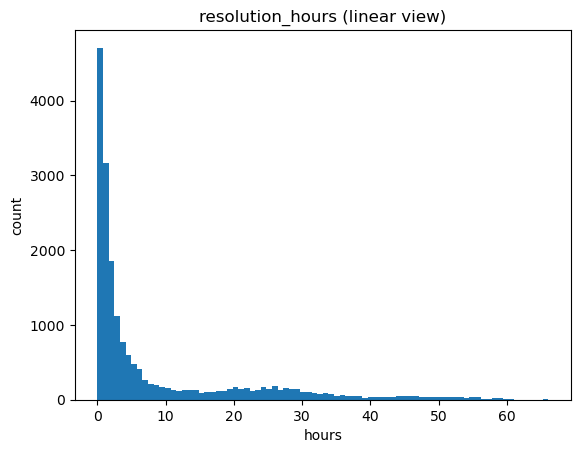

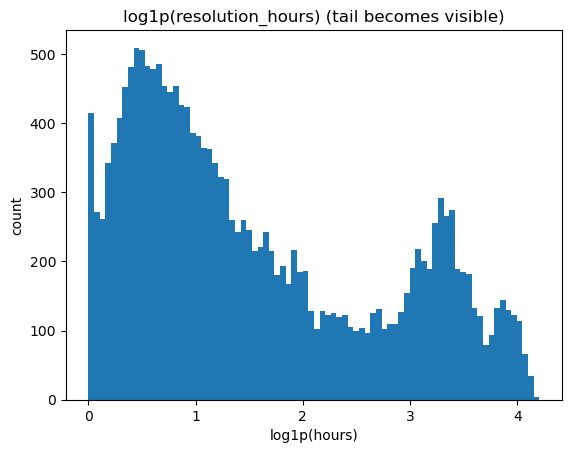

In [4]:
plt.figure()
plt.hist(y, bins=80)
plt.title("resolution_hours (linear view)")
plt.xlabel("hours")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(np.log1p(y), bins=80)
plt.title("log1p(resolution_hours) (tail becomes visible)")
plt.xlabel("log1p(hours)")
plt.ylabel("count")
plt.show()

## 3E.3 Sampling Variability via Time Splits

The dataset is one sample. Even within one week, the estimate can vary across time slices.  

Because this dataset is ~ 1 week, we will use **day-by-day** and also a simple first-half vs second-half split

In [5]:
# Ensure created_day exists
if "created_day" not in dfc.columns:
    if "created_date" in dfc.columns:
        dfc["created_day"] = pd.to_datetime(dfc["created_date"], errors="coerce").dt.date
    else:
        raise ValueError("Need created_day or created_date to do time splits.")

days = sorted([d for d in dfc["created_day"].dropna().unique().tolist()])
print("Days in slice:", days)

def summarize_metric(s: pd.Series) -> dict:
    return {
        "n": int(s.size),
        "median": float(s.median()),
        "p95": float(s.quantile(0.95)),
    }

rows=[]
for d in days:
    s = dfc.loc[dfc["created_day"] == d, "resolution_hours"].dropna().astype(float)
    if len(s) < 200:
        continue
    r = summarize_metric(s)
    r["created_day"] = str(d)
    rows.append(r)

day_tbl = pd.DataFrame(rows).sort_values("created_day")
day_tbl

Days in slice: [datetime.date(2026, 1, 27), datetime.date(2026, 1, 28), datetime.date(2026, 1, 29), datetime.date(2026, 1, 30)]


,n,median,p95,created_day
0,7109,4.429444,50.172167,2026-01-27
1,6817,2.536667,30.207444,2026-01-28
2,4846,1.410694,9.846597,2026-01-29


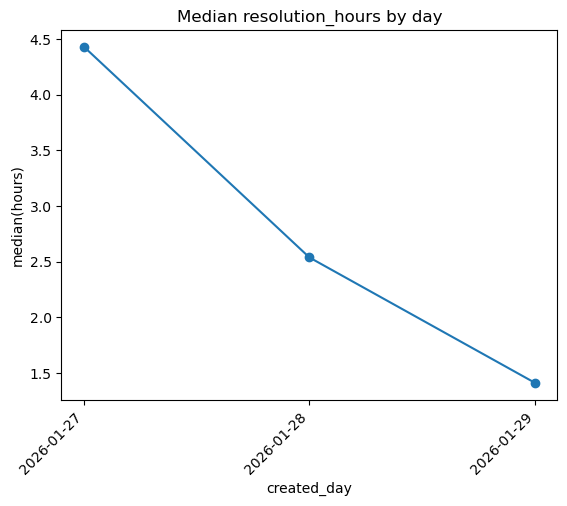

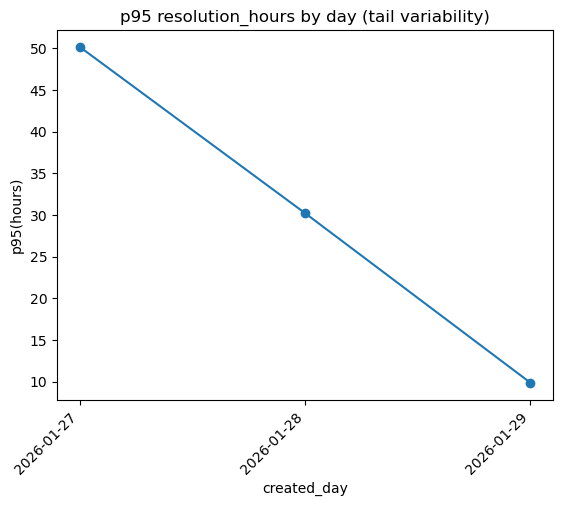

In [6]:
# Plot medians and p95 by day (sampling variability / composition changes)
plt.figure()
plt.plot(day_tbl["created_day"], day_tbl["median"], marker="o")
plt.title("Median resolution_hours by day")
plt.xlabel("created_day")
plt.ylabel("median(hours)")
plt.xticks(rotation=45, ha="right")
plt.show()

plt.figure()
plt.plot(day_tbl["created_day"], day_tbl["p95"], marker="o")
plt.title("p95 resolution_hours by day (tail variability)")
plt.xlabel("created_day")
plt.ylabel("p95(hours)")
plt.xticks(rotation=45, ha="right")
plt.show()

In [7]:
# First half vs second half split (coarser, but often more stable)
mid = len(days)//2
days_A = set(days[:mid])
days_B = set(days[mid:])

A = dfc[dfc["created_day"].isin(days_A)]["resolution_hours"].dropna().astype(float)
B = dfc[dfc["created_day"].isin(days_B)]["resolution_hours"].dropna().astype(float)

print("Split A days:", sorted(days_A))
print("Split B days:", sorted(days_B))
print("\nA:", summarize_metric(A))
print("B:", summarize_metric(B))
print("\nΔ median (B - A):", float(B.median() - A.median()))
print("Δ p95 (B - A):", float(B.quantile(0.95) - A.quantile(0.95)))

Split A days: [datetime.date(2026, 1, 27), datetime.date(2026, 1, 28)]
Split B days: [datetime.date(2026, 1, 29), datetime.date(2026, 1, 30)]

A: {'n': 13926, 'median': 3.2508333333333335, 'p95': 43.986666666666665}
B: {'n': 4968, 'median': 1.3666666666666667, 'p95': 9.734972222222218}

Δ median (B - A): -1.8841666666666668
Δ p95 (B - A): -34.251694444444446


## 3E.4 Bootstrap Intervals for Median and p95


Bootstrap = resample rows **with replacement** from your observed dataset and recompute the statistic.  

We will bootsrap:
* median (resolution_hours)
* p95 (resolution_hours) - tail estimate

In [8]:
def bootstrap_stat(x: np.ndarray, stat_fn, B: int = 4000, rng: np.random.Generator | None = None) -> np.ndarray:
    if rng is None:
        rng = np.random.default_rng(0)
    n = len(x)
    stats = np.empty(B, dtype=float)
    for b in range(B):
        idx = rng.integers(0, n, size=n)  # with replacement
        stats[b] = stat_fn(x[idx])
    return stats

x_all = dfc["resolution_hours"].dropna().astype(float).to_numpy()

B = 4000
boot_med = bootstrap_stat(x_all, np.median, B=B, rng=rng)
boot_p95 = bootstrap_stat(x_all, lambda z: np.quantile(z, 0.95), B=B, rng=rng)

def interval(a: np.ndarray, lo=0.025, hi=0.975):
    return float(np.quantile(a, lo)), float(np.quantile(a, hi))

med_lo, med_hi = interval(boot_med)
p95_lo, p95_hi = interval(boot_p95)

print("Point estimates (full slice):")
print("  median:", float(np.median(x_all)))
print("  p95   :", float(np.quantile(x_all, 0.95)))
print("\nBootstrap 95% intervals:")
print("  median:", (med_lo, med_hi), "width:", med_hi - med_lo)
print("  p95   :", (p95_lo, p95_hi), "width:", p95_hi - p95_lo)


Point estimates (full slice):
  median: 2.318888888888889
  p95   : 38.25131944444444

Bootstrap 95% intervals:
  median: (2.253888888888889, 2.4) width: 0.14611111111111086
  p95   : (37.277638888888866, 39.566734374999996) width: 2.2890954861111297


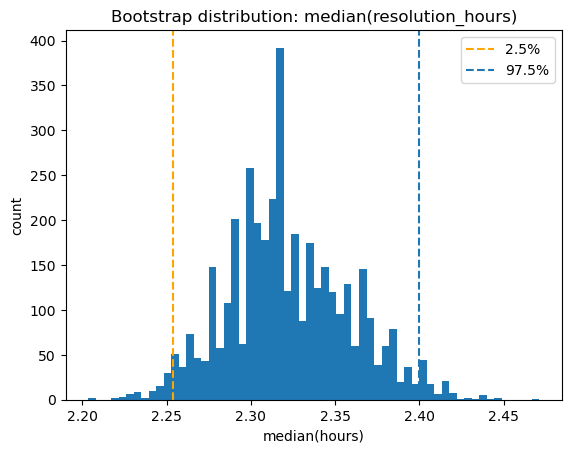

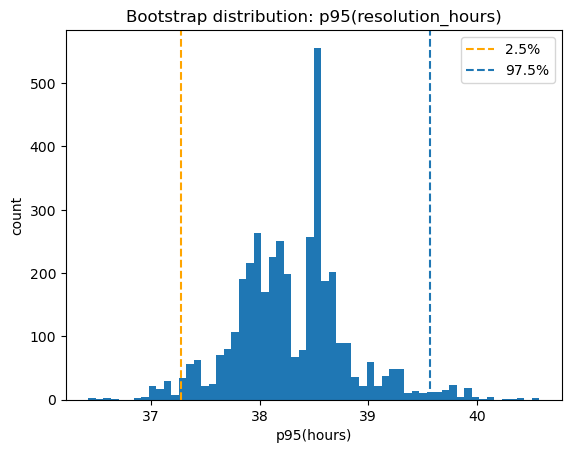

In [9]:
# Plot bootstrap distributions (intervals visualized)
plt.figure()
plt.hist(boot_med, bins=60)
plt.axvline(med_lo, linestyle="--", color="orange", label="2.5%")
plt.axvline(med_hi, linestyle="--", label="97.5%")
plt.title("Bootstrap distribution: median(resolution_hours)")
plt.xlabel("median(hours)")
plt.ylabel("count")
plt.legend()
plt.show()

plt.figure()
plt.hist(boot_p95, bins=60)
plt.axvline(p95_lo, linestyle="--", color="orange", label="2.5%")
plt.axvline(p95_hi, linestyle="--", label="97.5%")
plt.title("Bootstrap distribution: p95(resolution_hours)")
plt.xlabel("p95(hours)")
plt.ylabel("count")
plt.legend()
plt.show()


## 3E.5 Group Uncertainty: Bootstrap the Difference in Medians

Pick two groups (agencies or complaint types) and estimate:  
* median = median(group A) - median(group B)
* p95

We will pick two high-volume groups automatically, but can be overridden

In [10]:
# Choose a grouping column
group_candidates = [c for c in ["agency", "complaint_topk", "borough_norm"] if c in dfc.columns]
if not group_candidates:
    raise ValueError("Need 'agency' or 'complaint_topk' or 'borough_norm' column for group uncertainty.")

GROUP_COL = group_candidates[0]  # default, try a different group candidate
print("Using GROUP_COL:", GROUP_COL)

# Pick two largest groups by count
vc = dfc[GROUP_COL].astype(str).value_counts()
g1, g2 = vc.index[0], vc.index[1]   # Default compare the first two, try comparing different strata within the group
print("Auto-picked groups:", g1, "vs", g2)
print("Counts:", int(vc.iloc[0]), int(vc.iloc[1]))

x1 = dfc[dfc[GROUP_COL].astype(str) == g1]["resolution_hours"].dropna().astype(float).to_numpy()
x2 = dfc[dfc[GROUP_COL].astype(str) == g2]["resolution_hours"].dropna().astype(float).to_numpy()

print("Group A median/p95:", float(np.median(x1)), float(np.quantile(x1, 0.95)))
print("Group B median/p95:", float(np.median(x2)), float(np.quantile(x2, 0.95)))


Using GROUP_COL: agency
Auto-picked groups: NYPD vs HPD
Counts: 11440 4458
Group A median/p95: 1.2780555555555555 6.4023194444444425
Group B median/p95: 23.354861111111113 52.48579166666666


In [11]:
def bootstrap_delta(xa: np.ndarray, xb: np.ndarray, stat_fn, B: int = 4000, rng: np.random.Generator | None = None) -> np.ndarray:
    if rng is None:
        rng = np.random.default_rng(0)
    na, nb = len(xa), len(xb)
    out = np.empty(B, dtype=float)
    for b in range(B):
        ia = rng.integers(0, na, size=na)
        ib = rng.integers(0, nb, size=nb)
        out[b] = stat_fn(xa[ia]) - stat_fn(xb[ib])
    return out

B = 4000
delta_med = bootstrap_delta(x1, x2, np.median, B=B, rng=rng)
delta_p95 = bootstrap_delta(x1, x2, lambda z: np.quantile(z, 0.95), B=B, rng=rng)

dmed_lo, dmed_hi = interval(delta_med)
dp95_lo, dp95_hi = interval(delta_p95)

print(f"Δ median ({g1} - {g2}) point:", float(np.median(x1) - np.median(x2)))
print("Bootstrap 95% interval:", (dmed_lo, dmed_hi))

print(f"\nΔ p95 ({g1} - {g2}) point:", float(np.quantile(x1,0.95) - np.quantile(x2,0.95)))
print("Bootstrap 95% interval:", (dp95_lo, dp95_hi))


Δ median (NYPD - HPD) point: -22.07680555555556
Bootstrap 95% interval: (-22.698350694444446, -21.519579861111115)

Δ p95 (NYPD - HPD) point: -46.08347222222221
Bootstrap 95% interval: (-46.83232256944444, -45.23242256944443)


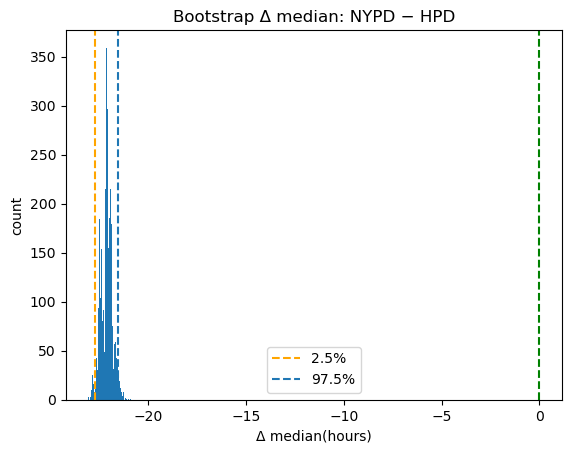

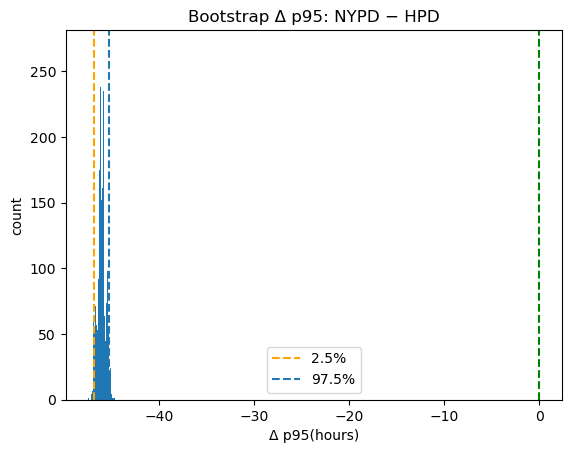

In [12]:
plt.figure()
plt.hist(delta_med, bins=60)
plt.axvline(dmed_lo, linestyle="--", color="orange", label="2.5%")
plt.axvline(dmed_hi, linestyle="--", label="97.5%")
plt.axvline(0, color="green", linestyle="--")
plt.title(f"Bootstrap Δ median: {g1} − {g2}")
plt.xlabel("Δ median(hours)")
plt.ylabel("count")
plt.legend()
plt.show()

plt.figure()
plt.hist(delta_p95, bins=60)
plt.axvline(dp95_lo, linestyle="--", color="orange", label="2.5%")
plt.axvline(dp95_hi, linestyle="--", label="97.5%")
plt.axvline(0, color="green", linestyle="--")
plt.title(f"Bootstrap Δ p95: {g1} − {g2}")
plt.xlabel("Δ p95(hours)")
plt.ylabel("count")
plt.legend()
plt.show()


## 3E.6 Sability Check: Does the Top Agency Remain Top Under Resampling

A common EDA claim is "Agency X is worst by p95"  

Here we ask: **is that ranking stable under bootstrap resampling**  

We will rank agencies by **p95 resolution_hours** and then bootstrap the ranking

In [13]:
if "agency" not in dfc.columns:
    raise ValueError("Need 'agency' column for top-agency stability check.")

def agency_metric_table(df: pd.DataFrame, metric: str = "p95", min_n: int = 200) -> pd.DataFrame:
    rows=[]
    for a, g in df.groupby(df["agency"].astype(str)):
        s = g["resolution_hours"].dropna().astype(float)
        if len(s) < min_n:
            continue
        if metric == "median":
            v = float(s.median())
        elif metric == "p95":
            v = float(s.quantile(0.95))
        else:
            raise ValueError("metric must be 'median' or 'p95'")
        rows.append({"agency": a, "n": int(len(s)), metric: v})
    return pd.DataFrame(rows).sort_values(metric, ascending=False)

base_tbl = agency_metric_table(dfc, metric="p95", min_n=200)
base_tbl.head(10)

,agency,n,p95
4,HPD,4458,52.485792
1,DHS,227,49.234139
3,DSNY,794,46.265167
2,DOT,755,29.547472
0,DEP,711,28.458333
5,NYPD,11440,6.402319


In [14]:
# Bootstrap: resample rows, recompute agency p95 table, record the top agency
B = 800  # keep runtime reasonable
top_counts = {}

for b in range(B):
    idx = rng.integers(0, len(dfc), size=len(dfc))
    boot = dfc.iloc[idx]
    tbl = agency_metric_table(boot, metric="p95", min_n=200)
    if len(tbl) == 0:
        continue
    top = tbl.iloc[0]["agency"]
    top_counts[top] = top_counts.get(top, 0) + 1

top_share = pd.DataFrame(
    [{"agency": k, "share": v / B, "wins": v} for k, v in top_counts.items()]
).sort_values("share", ascending=False)

print("Top agency stability (by p95):")
print(top_share.head(10).to_string(index=False))

Top agency stability (by p95):
agency   share  wins
   HPD 0.92500   740
   DHS 0.05375    43
  DSNY 0.02125    17


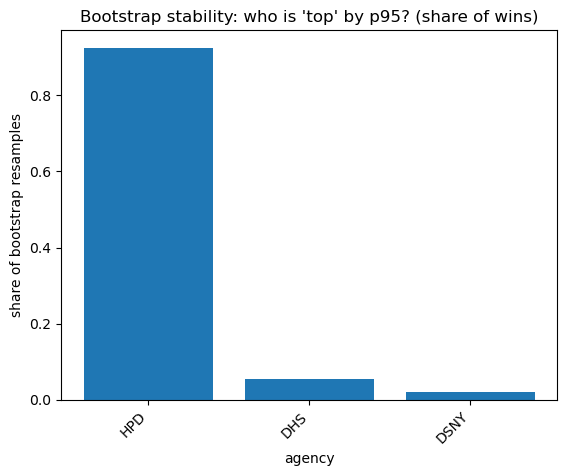

Interpretation tip:
- If the top agency wins ~90%+ of resamples, the claim is fairly stable.
- If it wins ~20–40%, the ranking is fragile (noise/composition).


In [15]:
plt.figure()
plt.bar(top_share["agency"].head(12), top_share["share"].head(12))
plt.title("Bootstrap stability: who is 'top' by p95? (share of wins)")
plt.xlabel("agency")
plt.ylabel("share of bootstrap resamples")
plt.xticks(rotation=45, ha="right")
plt.show()

print("Interpretation tip:")
print("- If the top agency wins ~90%+ of resamples, the claim is fairly stable.")
print("- If it wins ~20–40%, the ranking is fragile (noise/composition).")

## 3E.7 Deliverable 1-2 Plots + A Short Paragraph

Write a short paragraph in this structure:  
* **What I estimate:** metric, group, time window
* **How Uncertain I am:** interval width, whether it includes 0 for differences, stability share for rankings
* **What I would do next:** more data, stratify, different metric, or a designed test  

### Deliverable template - example

**What I estimate:**  
- I estimate the **median** resolution time is ____ hours (95% bootstrap interval: [____, ____]).  
- I estimate the **p95** resolution time is ____ hours (95% bootstrap interval: [____, ____]).  

**Group difference:**  
- Comparing **{GROUP_COL} = {g1} vs {g2}**, I estimate Δ median is ____ hours (95% interval: [____, ____]).  
  (If the interval includes 0, the direction is not stable.)

**Stability:**  
- The “top agency by p95” wins ____% of bootstrap resamples.  
  (High share = stable claim; low share = fragile ranking.)

**Next step:**  
- I would next ____ (stratify by complaint type / collect a longer time window / check missingness / etc.).


### Final Deliverable  

**What I estimate:**  
* Over the analysis window (Jan 27-30, 2026), I estimate the median resolution time for closed NYC311 requests is **2.32 hours** (95% bootstrap interval: [2.25, 2.40], width: 0.15h ).
* I estimate the p95 resolution time is **38.25 hours** (95% bootstrap interval:[37.28, 39.57], width:2.39h).
* The median estimate is precise, while the p95 interval is roughly 15x wider. Consistent with a heavy-tailed distribution.

**Group difference:**  
* Comparing NYPD (n=11,440) vs HPD (n=4,458). I estimate &Delta; median is **-22.08 hours** (95% interval: [-22.70, -21.52]). I estimate &Delta; p95 is **-46.08 hours** (95% interval: [-46.83, -45.23]). Neither interval includes 0, so the direction is stable. HPD is reliably slower than NYPD at both the typical and tail case.

**Stability:**  
* The bootstrap 95% CI for the median:[2.25, 2.40] has a width of only 0.15h, meaning even with resampling noise the median stays tightly bounded around 2.32h. The p95 CI:[37.28, 39.57] is wider at 2.29h but still narrow enough to be informative.

**Next Step:**  
* The day-by-day split showed median dropping from 4.43h on Jan 27 to 1.41h on Jan 29. Also, a p95 dropping from 50.2 to 9.8h, a ~5x fall in three days. Before drawing any conclusions about trends, I would extend the observation window to allow long-running cases to close. Then, I would stratify the bootstrap comparision by complaint type to test whether the NYPD/HPD gap survives controlling for the complaint mix each agency handles.